In [1]:
# !pip install jupyterlab-lsp==4.1.0
# !pip install -U jedi-language-server

In [1]:
!python -m pip install ujson

In [2]:
!pip install optuna

In [3]:
import ujson as json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, BallTree
from tqdm.notebook import tqdm
# from concurrent.futures import ProcessPoolExecutor

import os
# import dill
import pickle
import ast
import random
# import optuna

In [4]:
torch.__version__, torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name(0)

('1.12.1+cu116', True, 0, 'NVIDIA RTX A4000')

In [5]:
DATA_PATH = './data'

In [6]:
embeddings_df = pd.read_parquet(f'{DATA_PATH}/output_10k.parquet')
reference_embeddings_df = pd.read_parquet(f'{DATA_PATH}/references_output_100k.parquet')

embeddings = embeddings_df.to_dict('records')
reference_embeddings = reference_embeddings_df.to_dict('records')

with open(f'{DATA_PATH}/metadata_10k_full.json', 'r') as f:
    metadata = json.load(f)

with open(f'{DATA_PATH}/references_metadata_formatted.json', 'r') as f:
    reference_metadata = json.load(f)

In [7]:
len(embeddings), len(reference_embeddings), len(metadata), len(reference_metadata)

(9922, 108173, 9922, 108173)

In [8]:
# Filter all_ref_ids with non-null years using list comprehension
all_ref_ids = [e['paper_id'] for e in reference_embeddings if reference_metadata[e['paper_id']]['year'] is not None]

len(all_ref_ids)

107883

In [8]:
# # remove ref_ids with null year
# all_ref_ids = [e['paper_id'] for e in reference_embeddings]
# null_year_ref_ids = [pid for pid in all_ref_ids if reference_metadata[pid]['year'] is None]
# null_year_ref_ids_set = set(null_year_ref_ids)
# all_ref_ids = list(set(all_ref_ids) - null_year_ref_ids_set)

# reference_metadata = {k:v for k,v in reference_metadata.items() if k not in null_year_ref_ids_set}
# reference_embeddings = [e for e in reference_embeddings if e['paper_id'] not in null_year_ref_ids_set]

# # originally there were 10K papers, however removing papers with null title/abstract or 0 references resulted in 700 less
# all_paper_ids = [e['paper_id'] for e in embeddings]
# zero_ref_pids = [pid for pid in all_paper_ids if len(ast.literal_eval(metadata[pid]['references'])) == 0]
# all_paper_ids = list(set(all_paper_ids) - set(zero_ref_pids))
# all_pid_set = set(all_paper_ids)

# common_pid_set = set(all_paper_ids) & set(all_ref_ids)

# all_pids = all_paper_ids + [pid for pid in all_ref_ids if pid not in common_pid_set]

# embeddings = [e for e in embeddings if e['paper_id'] in all_pid_set]

# metadata = {k:v for k,v in metadata.items() if k in all_pid_set}

# for pid in metadata:
#     p = metadata[pid]
#     p['references'] = ast.literal_eval(p['references'])
    
# metadata = {**metadata, **{k: v for k, v in reference_metadata.items() if k not in metadata}}


In [9]:
filtered_reference_metadata = {}
filtered_reference_embeddings = []
filtered_metadata = {}
filtered_embeddings = []

all_paper_ids = set()
all_ref_ids = set()

for e in reference_embeddings:
    paper_id = e['paper_id']
    if reference_metadata[paper_id]['year'] is not None:
        filtered_reference_metadata[paper_id] = reference_metadata[paper_id]
        filtered_reference_embeddings.append(e)
        all_ref_ids.add(paper_id)

reference_metadata = filtered_reference_metadata
reference_embeddings = filtered_reference_embeddings

for e in embeddings:
    paper_id = e['paper_id']
    p = metadata[paper_id]
    p['references'] = ast.literal_eval(p['references'])

    if len(p['references']) > 0:
        all_paper_ids.add(paper_id)
        filtered_metadata[paper_id] = p
        filtered_embeddings.append(e)

embeddings = filtered_embeddings
metadata = filtered_metadata

common_pid_set = all_paper_ids & all_ref_ids
all_pids = list(all_paper_ids | all_ref_ids)

metadata = {**metadata, **{k: v for k, v in reference_metadata.items() if k not in metadata}}


In [10]:
len(all_paper_ids), len(all_ref_ids)

(9319, 107883)

In [11]:
# Maybe a list of all references needed if we are preparing reranking model data randomly and
# need to compare years of the references to the query paper (to ensure the model does not have 
# access to future information 

all_references = set()
ref_len_lst = []
for pid in filtered_metadata:
    p = filtered_metadata[pid]
    p_refs = p['references']
    ref_len_lst.append(len(p_refs))
    all_references.update(p_refs)
len(all_references)

108246

In [12]:
def plot_stats(data, xlabel='Label Needed', title='Title Needed', bins=50):
    plt.hist(data, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')

    np_arr = np.array(data)

    mean_val = np.mean(np_arr)
    plt.axvline(mean_val, color='orange', linestyle='dashed', linewidth=1)
    plt.text(mean_val, plt.ylim()[1]*0.5, f'Mean: {mean_val:.2f}', rotation=45, color='orange')

    # Add a vertical line for the median
    median_val = np.median(np_arr)
    plt.axvline(median_val, color='red', linestyle='dashed', linewidth=1)
    plt.text(median_val, plt.ylim()[1]*0.25, f'Median: {median_val:.2f}', rotation=45, color='red')
    plt.title(title)
    plt.show()


In [40]:
# plt.hist(ref_len_lst, bins=50)
# plt.xlabel('Number of references')
# plt.ylabel('Frequency')

# np_arr = np.array(ref_len_lst)

# mean_val = np.mean(np_arr)
# plt.axvline(mean_val, color='orange', linestyle='dashed', linewidth=1)
# plt.text(mean_val, 50, f'Mean: {mean_val:.2f}', rotation=90, color='orange')


# # Add a vertical line for the median
# median_val = np.median(np_arr)
# plt.axvline(median_val, color='yellow', linestyle='dashed', linewidth=1)
# plt.text(median_val, 75, f'Median: {median_val:.2f}', rotation=90, color='yellow')


# plt.show()

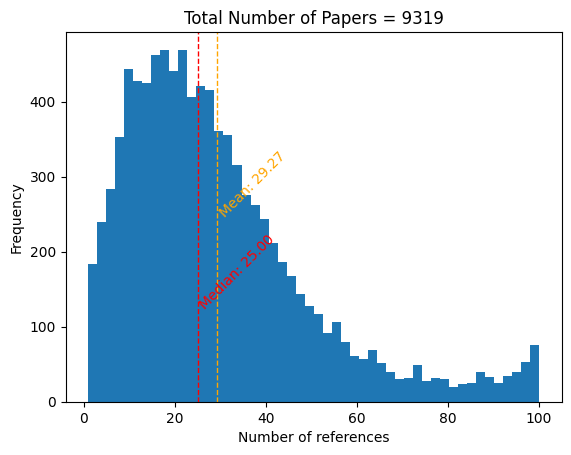

In [13]:
plot_stats(ref_len_lst, xlabel='Number of references', title=f'Total Number of Papers = {len(ref_len_lst)}')

In [14]:
len(embeddings) / len(all_references)

0.08609094100474844

In [29]:
# weights = torch.stack([torch.tensor(e['embedding']) for e in embeddings]).double()
# all_paper_ids = [e['paper_id'] for e in embeddings]

In [30]:
# reference_weights = torch.stack([torch.tensor(e['embedding']) for e in reference_embeddings]).double()

In [31]:
# reference_weights.shape, weights.shape

In [32]:
# weights = torch.cat((weights, reference_weights), dim=0)

In [15]:
len(embeddings), len(metadata), len(reference_metadata)

(9319, 107904, 107883)

In [16]:
try:
    metadata['659408b243cec55de8d0a3bc51b81173007aa89b']['references']
except KeyError:
    print('All good, papers with 0 references not stored')

All good, papers with 0 references not stored


In [17]:
metadata['204e3073870fae3d05bcbc2f6a8e263d9b72e776']

{'title': 'Attention is All you Need',
 'abstract': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best mo

In [24]:
# embedding_map = {}
# for obj in embeddings:
#     # object is a dict like {'paper_id': str, 'embedding': np.array}
#     paper_id, emb_768 = obj.values()
#     arr = np.asarray(emb_768)
#     embedding_map[paper_id] = torch.tensor(arr, dtype=torch.float32)

In [25]:
# embedding_map = {}
# for obj in reference_embeddings:
#     # object is a dict like {'paper_id': str, 'embedding': np.array}
#     paper_id, emb_768 = obj.values()
#     arr = np.asarray(emb_768)
#     embedding_map[paper_id] = torch.tensor(arr, dtype=torch.float32)

In [18]:
def embedding_dict_to_tensor(obj):
    paper_id, emb_768 = obj.values()
    arr = np.asarray(emb_768)
    return paper_id, torch.tensor(arr, dtype=torch.float32)

In [19]:
all_embeddings = embeddings + reference_embeddings
embedding_map = dict([embedding_dict_to_tensor(obj) for obj in all_embeddings])
len(embedding_map)

107904

In [20]:
embedding_matrix = np.array([embedding_map[paper_id].numpy() for paper_id in all_pids])
embedding_matrix.shape

(107904, 768)

In [21]:
# We can use l2 distance ªas cosine distance isn't really a thing in sklearn BallTree/KDTree) so long as the input matrix is l2 normalized
# in this case it will result in the same ordering as a cosine distance
# https://stackoverflow.com/questions/34144632/using-cosine-distance-with-scikit-learn-kneighborsclassifier
knn_tree = BallTree(embedding_matrix, metric='l2')

In [22]:
reference_map = {}
# fetch references from metadata dict in the format {paper_id: [list of references]}
for paper_id in all_paper_ids:
    # references = ast.literal_eval(metadata[paper_id].get('references'))
    references = metadata[paper_id].get('references')
    reference_map[paper_id] = references or []
len(reference_map)

9319

In [23]:
all_years = [metadata[pid]['year'] for pid in all_paper_ids]
min(all_years), len(all_years)

(1855, 9319)

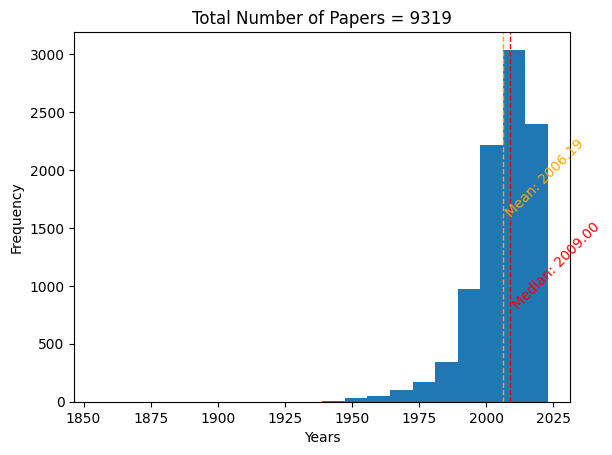

In [24]:
plot_stats(all_years, xlabel='Years', title=f'Total Number of Papers = {len(all_years)}', bins=20)

In [25]:
all_paper_ids = list(all_paper_ids)
train_paper_ids, test_paper_ids = train_test_split(all_paper_ids, test_size=0.2, random_state=42)
val_paper_ids, test_paper_ids = train_test_split(test_paper_ids, test_size=0.5, random_state=42)

In [26]:
len(train_paper_ids) +  len(val_paper_ids) + len(test_paper_ids)

9319

In [27]:
specter_tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
specter_model = AutoModel.from_pretrained('allenai/specter')

In [28]:
@torch.no_grad()
def get_embedding(paper, embedding_map=None):
    '''
    Given an input paper (dict with at least 'title' as a key, returns a 768 dimensional embeddings using the SPECTER model from HF.
    '''
    assert type(paper)==dict and 'title' in paper.keys(), "paper must be a dict with at least 'title' as a key"
    if embedding_map and paper['paper_id'] is not None and paper['paper_id'] in embedding_map:
        return embedding_map[paper['paper_id']].view(1,-1)
    # tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
    # model = AutoModel.from_pretrained('allenai/specter')
    title_abs = [d['title'] + specter_tokenizer.sep_token + (d.get('abstract') or '') for d in [paper]]
    inputs = specter_tokenizer(title_abs, padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = specter_model(**inputs)
    cur_embedding = result.last_hidden_state[:, 0, :]
    return cur_embedding

In [29]:
def find_knn(cur_embedding, knn_tree, knn_k):
    '''
    Given a SPECTER embedding (shape = [1,768]), a KNN Tree and knn_k (number of nearest neighbours), returns the top indices from the knn_tree
    '''
    # assert(cur_embedding.shape==(1,768))
    
    # this score isn't really a score but distance rather (not cosine similarity)
    # this becaues BallTree don't support cosine distance :(
    scores, top_indices = knn_tree.query(cur_embedding.reshape(1,-1), k=knn_k, return_distance=True)
    scores, top_indices = np.squeeze(scores), np.squeeze(top_indices)
    return top_indices, scores
    

In [30]:
def find_knn_pid(pid, knn_tree, embedding_map, metadata, all_paper_ids, knn_k, return_scores=False):
    '''
    '''
    paper_embedding = get_embedding(metadata[pid], embedding_map)
    top_indices, scores = find_knn(paper_embedding, knn_tree, knn_k=knn_k)
    recommended_paper_ids = [all_paper_ids[i] for i in top_indices]
    if return_scores:
        return recommended_paper_ids, scores
    return recommended_paper_ids

In [30]:
## V1
# @torch.no_grad()
# def find_similar_knn(cur_embedding, embedding_map, k=10, least = False):
#     # current_embeddings shape: [1,768]
#     # weights shape: [num_of_egs, embedding_dim=768]
#     # cur_embedding = get_embedding(paper)
#     # input shape should be [1,768]
#     weights = 
#     assert(torch.is_tensor(cur_embedding))
#     # print(cur_embedding.shape)
#     assert(cur_embedding.shape==(1,768))
#     weights_norm = F.normalize(weights, p=2, dim=1).double() # (N, d)
#     cur_em_norm = F.normalize(cur_embedding, p=2, dim=1).double() # (1, d)
#     cos_sim = F.cosine_similarity(weights_norm, cur_em_norm, dim=1)
#     topk = torch.topk(cos_sim, k, largest = False if least else True)
#     top_indices = topk.indices
#     top_values = topk.values
#     return top_indices, top_values

## V2

# @torch.no_grad()
# def find_similar_knn(cur_embedding, weights, k=10, least = False):
#     # current_embeddings shape: [1,768]
#     # weights shape: [num_of_egs, embedding_dim=768]
#     # cur_embedding = get_embedding(paper)
#     # input shape should be [1,768]
#     assert(torch.is_tensor(cur_embedding))
#     # print(cur_embedding.shape)
#     assert(cur_embedding.shape==(1,768))
#     weights_norm = F.normalize(weights, p=2, dim=1).double() # (N, d)
#     cur_em_norm = F.normalize(cur_embedding, p=2, dim=1).double() # (1, d)
#     cos_sim = F.cosine_similarity(weights_norm, cur_em_norm, dim=1)
#     topk = torch.topk(cos_sim, k, largest = False if least else True)
#     top_indices = topk.indices
#     top_values = topk.values
#     return top_indices, top_values

In [31]:
def evaluate(recommended, actual, top_k):
    recommended = np.asarray(recommended)[:top_k] if top_k else np.asarray(recommended)
    actual = np.asarray(actual)
    
    if len(actual) == 0:
        print('No actual references stored in the metadata')
        return 0,0,0
    
    true_positives = np.intersect1d(recommended, actual)
    false_positives = np.setdiff1d(recommended, actual)
    false_negatives = np.setdiff1d(actual, recommended)
    
    assert(len(true_positives) + len(false_positives) == len(recommended))
    assert(len(true_positives) + len(false_negatives) == len(actual))

    precision = len(true_positives) / (len(true_positives) + len(false_positives))
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score


In [36]:
# a3e4ceb42cbcd2c807d53aff90a8cb1f5ee3f031
new_title = 'SPECTER: Document-level Representation Learning using Citation-informed Transformers'

new_abstract = 'We propose SPECTER, a new method to generate document-level embedding of scientific documents based on pretraining a Transformer language model on a powerful signal of document-level relatedness: the citation graph. Unlike existing pretrained language models, SPECTER can be easily applied to downstream applications without task-specific fine-tuning. Additionally, to encourage further research on document-level models, we introduce SciDocs, a new evaluation benchmark consisting of seven document-level tasks ranging from citation prediction, to document classification and recommendation. We show that SPECTER outperforms a variety of competitive baselines on the benchmark.'

In [32]:
# # 204e3073870fae3d05bcbc2f6a8e263d9b72e776
# new_title = 'Attention Is All You Need'
# new_abstract = 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.'

In [33]:
new_title = 'Refpred - A Research Paper Recommendation System based on SPECTER'
new_abstract = 'The literature review is an essential part of the research process, as it helps researchers understand the current state of knowledge in their field and identify gaps that their own research can address. However, the current review process with manual paper searching, can be time-consuming and labour-intensive. This is particularly true for researchers working in fields with large and rapidly-growing bodies of literature such as Medicine or Machine Learning. To tackle this issue, we aim to build RefPred - a system that uses a citation-informed transformer with a recommendation engine to recommend relevant papers to assist researchers in review process. Specifically, given a new title/abstract, it should be able to predict the most relevant papers and sort them according to some metric (such as citation count or similarity score). For doing this, we create a dataset comprising of thousands of research paper metadata (sourced from Semantic Scholar) by crawling it asynchronously and storing locally on a MongoDB database. We then use citation-informed transformer model SPECTER to embed each paper, capturing it’s citation and semantic meaning simultaneously.  With paper embeddings, we can construct an embedding space of papers, which will be used to build a recommendation engine based on various algorithms (like KNN as a baseline) to give relevant recommendations for a new paper. Finally, we propose a novel approach to use neural network to rerank the initial KNN candidates, resulting in 27% better Precision and Recall @ 20 scores on the test set over the baseline KNN approach.'

In [34]:
def get_knn_new_paper(title, abstract, knn_tree, all_paper_ids, knn_k, return_scores=False):
    '''
    Given a new title and abstract, get the knn_k nearest neighbours from the knn_tree. The order of knn_tree and all_paper_ids must be the same.
    '''
    new_paper_obj = {'title':title, 'abstract': abstract}
    print(new_paper_obj)
    new_paper_embedding = get_embedding(new_paper_obj)
    top_indices, scores = find_knn(new_paper_embedding, knn_tree, knn_k=knn_k)
    recommended_paper_ids = [all_paper_ids[i] for i in top_indices]
    if return_scores:
        return recommended_paper_ids, scores
    return recommended_paper_ids

In [35]:
def print_papers(pids, metadata, break_at=20):
    for i, pid in enumerate(pids):
        title = metadata[pid]['title']
        # abstract = metadata[paper_id]['abstract']
        year = metadata[pid]['year']
        if 'SPECTER' in title:
            print(i)
        print(f'Paper ID: {pid}\nTitle: {title}\nYear: {year}')
        if i == break_at:
            break

In [36]:
len(train_paper_ids), len(val_paper_ids), len(test_paper_ids)

(7455, 932, 932)

In [37]:
len(reference_embeddings)

107883

In [38]:
new_knn_paper_ids = get_knn_new_paper(new_title, new_abstract, knn_tree, all_pids, knn_k=1000)
# for i, pid in enumerate(new_knn_paper_ids):
#     title = metadata[pid]['title']
#     # abstract = metadata[paper_id]['abstract']
#     year = metadata[pid]['year']
#     if 'SPECTER' in title:
#         print(i)
#     print(f'Paper ID: {pid}\nTitle: {title}\nYear: {year}')# \nCosine similarity: {cos_sim}\n')
#     if i == 100:
#         break
print_papers(new_knn_paper_ids, metadata, break_at=100)

{'title': 'Refpred - A Research Paper Recommendation System based on SPECTER', 'abstract': 'The literature review is an essential part of the research process, as it helps researchers understand the current state of knowledge in their field and identify gaps that their own research can address. However, the current review process with manual paper searching, can be time-consuming and labour-intensive. This is particularly true for researchers working in fields with large and rapidly-growing bodies of literature such as Medicine or Machine Learning. To tackle this issue, we aim to build RefPred - a system that uses a citation-informed transformer with a recommendation engine to recommend relevant papers to assist researchers in review process. Specifically, given a new title/abstract, it should be able to predict the most relevant papers and sort them according to some metric (such as citation count or similarity score). For doing this, we create a dataset comprising of thousands of res

In [102]:
### MUCH MUCH FASTER ALGORITHM PRESENT BELOW
# # new_paper = {'title': new_title, 'abstract': new_abstract or ''}
# # assert new_paper['title'] is not None
# # paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
# k = 20
# test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
# paper_embedding = get_embedding(metadata[test_paper_id])
# top_indices, top_values = find_similar_knn(paper_embedding, weights, k=50, least=False)
# recommended_paper_ids = [all_paper_ids[i] for i in top_indices]


# cnt = 0
# for paper_id, cos_sim in zip(recommended_paper_ids, top_values):
#     title = metadata[paper_id]['title']
#     # abstract = metadata[paper_id]['abstract']
#     year = metadata[paper_id]['year']
#     print(f'Paper ID: {paper_id}\nTitle: {title}\nYear: {year}')# \nCosine similarity: {cos_sim}\n')
#     cnt += 1 
#     if cnt == 10:
#         break
        
# actual_references = ast.literal_eval(metadata[test_paper_id].get('references'))

# print('-'*100)

# precision, recall, f1_score = evaluate(recommended_paper_ids[1:], actual_references, k=k)
# print(f'For the Paper - {metadata[test_paper_id]["title"]}')
# print(f"Precision @ {k}: {precision}")
# print(f"Recall @ {k}: {recall}")
# print(f"F1 Score: {f1_score}")

In [52]:
metadata['204e3073870fae3d05bcbc2f6a8e263d9b72e776']

{'title': 'Attention is All you Need',
 'abstract': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best mo

In [39]:
# Cosine scores not available because BallTree doesn't have a cosine similarity metric however similar ranking is providied by normalized L2
test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
# test_paper_id = '09ebd9ad4fa21c0d56433ac57a4cd69e94c72281'
# test_paper = metadata[test_paper_id]
# print(test_paper)
knn_paper_ids = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=20)


# for i, pid in enumerate(knn_paper_ids):
#     title = metadata[pid]['title']
#     # abstract = metadata[paper_id]['abstract']
#     year = metadata[pid]['year']
#     print(f'Paper ID: {pid}\nTitle: {title}\nYear: {year}')# \nCosine similarity: {cos_sim}\n')

print_papers(knn_paper_ids, metadata)

# NOT NEEDED as this is already done during metadata init
# actual_references = ast.literal_eval(metadata[test_paper_id].get('references'))
actual_references = metadata[test_paper_id].get('references')

print('-'*100)

precision, recall, f1_score = evaluate(knn_paper_ids[1:], actual_references, top_k=20)
print(f'For the Paper - {metadata[test_paper_id]["title"]}')
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")
print(f"F1 Score: {f1_score}")

Paper ID: 204e3073870fae3d05bcbc2f6a8e263d9b72e776
Title: Attention is All you Need
Year: 2017
Paper ID: c2f62a32b11f1906f5a3508b22134631cbfaa268
Title: Sockeye: A Toolkit for Neural Machine Translation
Year: 2017
Paper ID: 9ae0a24f0928cab1554a6ac880f6b350f85be698
Title: One Model To Learn Them All
Year: 2017
Paper ID: b60abe57bc195616063be10638c6437358c81d1e
Title: Deep Recurrent Models with Fast-Forward Connections for Neural Machine Translation
Year: 2016
Paper ID: cf0545d9f171c8e2d88aed13cd7ad60ff2ab8fb5
Title: How Much Attention Do You Need? A Granular Analysis of Neural Machine Translation Architectures
Year: 2018
Paper ID: dbde7dfa6cae81df8ac19ef500c42db96c3d1edd
Title: Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation
Year: 2016
Paper ID: 43428880d75b3a14257c3ee9bda054e61eb869c0
Title: Convolutional Sequence to Sequence Learning
Year: 2017
Paper ID: 93499a7c7f699b6630a86fad964536f9423bb6d0
Title: Effective Approaches to Attention

In [54]:
# Paper ID: 204e3073870fae3d05bcbc2f6a8e263d9b72e776
# Title: Attention is All you Need
# Year: 2017
# Paper ID: 9ae0a24f0928cab1554a6ac880f6b350f85be698
# Title: One Model To Learn Them All
# Year: 2017
# Paper ID: b60abe57bc195616063be10638c6437358c81d1e
# Title: Deep Recurrent Models with Fast-Forward Connections for Neural Machine Translation
# Year: 2016
# Paper ID: dbde7dfa6cae81df8ac19ef500c42db96c3d1edd
# Title: Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation
# Year: 2016
# Paper ID: 43428880d75b3a14257c3ee9bda054e61eb869c0
# Title: Convolutional Sequence to Sequence Learning
# Year: 2017
# Paper ID: 93499a7c7f699b6630a86fad964536f9423bb6d0
# Title: Effective Approaches to Attention-based Neural Machine Translation
# Year: 2015
# Paper ID: 4550a4c714920ef57d19878e31c9ebae37b049b2
# Title: Massive Exploration of Neural Machine Translation Architectures
# Year: 2017
# Paper ID: 2f2d8f8072e5cc9b296fad551f65f183bdbff7aa
# Title: Exploring the Limits of Language Modeling
# Year: 2016
# Paper ID: bb669de2fce407df2f5cb2f8c51dedee3f467e04
# Title: The Best of Both Worlds: Combining Recent Advances in Neural Machine Translation
# Year: 2018
# Paper ID: 25eb839f39507fe6983ad3e692b2f8d93a5cb0cc
# Title: Montreal Neural Machine Translation Systems for WMT’15
# Year: 2015
# Paper ID: 247328a082d86199ed5a98e1d726aa205c1da9df
# Title: Neural Machine Translation
# Year: 2017
# ----------------------------------------------------------------------------------------------------
# For the Paper - Attention is All you Need
# Precision @ 20: 0.3684210526315789
# Recall @ 20: 0.1891891891891892
# F1 Score: 0.25


For the Paper - Attention is All you Need\
Precision @ 20: 0.3684210526315789\
Recall @ 20: 0.1891891891891892\
F1 Score: 0.25\


In [40]:
def evaluate_knn(test_paper_ids, knn_tree, embedding_map, metadata, reference_map, all_paper_ids, knn_k):
    precisions = []
    recalls = []
    for paper_id in tqdm(test_paper_ids):
        # paper_embedding = embedding_map[paper_id]
        # # Query the KD-tree to find k nearest neighbors
        # top_indices = knn_tree.query(paper_embedding.reshape(1,-1), k=k, return_distance=False)[0]
        # recommendations = set([all_paper_ids[i] for i in top_indices])
        recommendations = set(find_knn_pid(paper_id, knn_tree, embedding_map, metadata, all_paper_ids, knn_k=knn_k))
        true_references = set(reference_map.get(paper_id, []))
        if not true_references:
            continue
        intersect = recommendations.intersection(true_references)
        precision = len(intersect) / len(recommendations)
        recall = len(intersect) / len(true_references)
        precisions.append(precision)
        recalls.append(recall)
    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    return mean_precision, mean_recall

In [51]:
# def evaluate_knn(test_paper_ids, embedding_map, reference_map, k=20):
#     precisions = []
#     recalls = []
#     for paper_id in tqdm(test_paper_ids):
#         paper_embedding = embedding_map[paper_id]
#         top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=k, least=False)
#         recommendations = set([all_paper_ids[i] for i in top_indices])
#         # recommendations = set(get_recommendations(model, paper_id, embedding_map, k=k))
#         true_references = set(reference_map.get(paper_id, []))
#         if not true_references:
#             continue

#         intersect = recommendations.intersection(true_references)
#         precision = len(intersect) / len(recommendations)
#         recall = len(intersect) / len(true_references)

#         # precision, recall, f1_score = evaluate(list(recommendations), list(true_references), k=k)
#         # print(f'({len(recommendations)},{len(true_references)}){precision=}    {recall=}')

#         precisions.append(precision)
#         recalls.append(recall)

#     mean_precision = sum(precisions) / len(precisions)
#     mean_recall = sum(recalls) / len(recalls)
#     return mean_precision, mean_recall

In [41]:
precision, recall = evaluate_knn(train_paper_ids[:100], knn_tree, embedding_map, metadata, reference_map, all_pids, knn_k=20)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

  0%|          | 0/100 [00:00<?, ?it/s]

Precision @ 20: 0.11999999999999998
Recall @ 20: 0.09522413442092616


In [40]:
precision, recall = evaluate_knn(test_paper_ids, knn_tree, embedding_map, metadata, reference_map, all_pids, knn_k=20)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

  0%|          | 0/932 [00:00<?, ?it/s]

Precision @ 20: 0.119849785407725
Recall @ 20: 0.09335762395515744


In [50]:
precision, recall = evaluate_knn(train_paper_ids, knn_tree, embedding_map, metadata, reference_map, all_pids, knn_k=20)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

  0%|          | 0/7455 [00:00<?, ?it/s]

Precision @ 20: 0.11829644533869745
Recall @ 20: 0.09614186570698526


In [49]:
precision, recall = evaluate_knn(val_paper_ids, knn_tree, embedding_map, metadata, reference_map, all_pids, knn_k=20)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

  0%|          | 0/932 [00:00<?, ?it/s]

Precision @ 20: 0.11786480686695257
Recall @ 20: 0.09928292552876614


### For test.txt IDs
Precision @ P20: 0.08703108252947454
Recall @ 20: 0.07151955632733407

## NN Based Re-ranking from the KNN candidates

In [58]:
## Spliting the Ids based on years
# paper_years = {paper_id: metadata[paper_id]['year'] for paper_id in all_paper_ids}

# sorted_paper_ids = sorted(all_paper_ids, key=lambda x: paper_years[x])

# split_1 = int(len(sorted_paper_ids) * 0.7)
# split_2 = int(len(sorted_paper_ids) * 0.9)

# train_paper_ids = sorted_paper_ids[:split_1]
# val_paper_ids = sorted_paper_ids[split_1:split_2]
# test_paper_ids = sorted_paper_ids[split_2:]

# len(train_paper_ids) +  len(val_paper_ids) + len(test_paper_ids)

In [41]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [34]:
# 26th April Latest Working
# This work but I forgot how ;(
class PaperPairDatasetOriginal(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, use_knn=True, knn_tree = None, check_year=True, data_file = None):#, num_positives=5, num_negatives=5):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        # self.num_positives = num_positives
        # self.num_negatives = num_negatives
        self.use_knn = use_knn
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        # self.paper_ids = list(embedding_map.keys())
        # if self.use_knn:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        # else:
        #     self.prepare_data_random()
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                self.data = pickle.load(f)
        elif self.use_knn:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    pickle.dump(self.data, f)
        else:
            self.prepare_data_random()
            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        # self.max_recalls = []
        # self.max_precisions = []
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            # paper_embedding = embedding_map[paper_id]
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int
            # top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=k, least=False)
            # recommendations = [self.all_paper_ids[i] for i in top_indices]
            
            recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k))
            # print(len(recommendations))
            actual_references = self.reference_map[paper_id]
            
            num_positives = len(set(actual_references) & recommendations)
            num_negatives = num_positives
            
            # self.max_recalls.append(num_positives/len(actual_references))
            # self.max_precisions.append(num_positives)
            
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            
            if len(actual_references) == 0:
                zero_ref_papers += 1
                
            for ref_id in recommendations:
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1           
                elif self.check_year and reference_year >= original_year and neg_count < num_negatives:
                    # skip KNN receommendations that were not present at the time of the paper
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue
                    
            # if i % 1000 == 0:
            #     print(f'{i} papers processed')
            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    def is_published_after(self, year1, year2):
        return int(year1 <= year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        year1 = self.metadata[paper_id1]['year']
        year2 = self.metadata[paper_id2]['year']
        is_after = self.is_published_after(year1, year2)
        # return torch.tensor(embedding1), torch.tensor(embedding2), torch.tensor(score, dtype=torch.float32)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [89]:
class PaperPairDataset(Dataset):
    def __init__(self, paper_ids, knn_tree, embedding_map, reference_map, metadata, all_paper_ids):
        self.paper_ids = paper_ids
        self.knn_tree = knn_tree
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        self.data = self.prepare_data()
    
    def prepare_data(self):
        data = []
        for query_paper_id in tqdm(self.paper_ids):
            query_year = self.metadata[query_paper_id]['year']
            # Get the KNN recommendations
            knn_indices = self.knn_tree.query(self.embedding_map[query_paper_id].reshape(1, -1), k=1000)[1][0]
            knn_paper_ids = [self.all_paper_ids[i] for i in knn_indices]
            
            # Filter out future papers
            knn_paper_ids = [paper_id for paper_id in knn_paper_ids if self.metadata[paper_id]['year'] <= query_year]

            for candidate_paper_id in knn_paper_ids:
                label = 1 if candidate_paper_id in self.reference_map[query_paper_id] else 0
                data.append((query_paper_id, candidate_paper_id, label))
        return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        query_paper_id, candidate_paper_id, label = self.data[idx]
        query_embedding = torch.tensor(self.embedding_map[query_paper_id], dtype=torch.float32)
        candidate_embedding = torch.tensor(self.embedding_map[candidate_paper_id], dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return query_embedding, candidate_embedding, label


In [42]:
class PaperPairDataset(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, knn_tree = None, check_year=True, data_file = None):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        
        # if data_file and os.path.exists(data_file):
        #     with open(data_file, 'rb') as f:
        #         self.data = pickle.load(f)
        # else:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        #     if data_file:
        #         with open(data_file, 'wb') as f:
        #             pickle.dump(self.data, f)
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                saved_data = pickle.load(f)
                self.data = saved_data['data']
                self.max_refs_present = saved_data['max_refs_present']
                self.total_refs = saved_data['total_refs']
                self.pos_neg_ratio = saved_data['pos_neg_ratio']
        else:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    saved_data = {
                        'data': self.data,
                        'max_refs_present': self.max_refs_present,
                        'total_refs': self.total_refs,
                        'pos_neg_ratio': self.pos_neg_ratio
                    }
                    pickle.dump(saved_data, f)

            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int
            
            recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k))
            actual_references = self.reference_map[paper_id]
            
            num_positives = len(set(actual_references) & recommendations)
            num_negatives = num_positives
            
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            
            if not actual_references:
                zero_ref_papers += 1
                
            for ref_id in recommendations:
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1           
                elif self.check_year and reference_year >= original_year and neg_count < num_negatives:
                    # skip KNN receommendations that were not present at the time of the paper
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue

            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    def is_published_after(self, year1, year2):
        return int(year1 <= year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        year1 = self.metadata[paper_id1]['year']
        year2 = self.metadata[paper_id2]['year']
        is_after = self.is_published_after(year1, year2)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [162]:
class PaperPairDatasetCoC(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, knn_tree = None, check_year=True, data_file = None):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        
        # if data_file and os.path.exists(data_file):
        #     with open(data_file, 'rb') as f:
        #         self.data = pickle.load(f)
        # else:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        #     if data_file:
        #         with open(data_file, 'wb') as f:
        #             pickle.dump(self.data, f)
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                saved_data = pickle.load(f)
                self.data = saved_data['data']
                self.max_refs_present = saved_data['max_refs_present']
                self.total_refs = saved_data['total_refs']
                self.pos_neg_ratio = saved_data['pos_neg_ratio']
        else:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    saved_data = {
                        'data': self.data,
                        'max_refs_present': self.max_refs_present,
                        'total_refs': self.total_refs,
                        'pos_neg_ratio': self.pos_neg_ratio
                    }
                    pickle.dump(saved_data, f)
                    
    def get_citations_of_citations(self, actual_references, reference_map, recommendations):
        citations_of_citations = set()
        for ref in actual_references:
            if ref in reference_map:
                citations = set(reference_map[ref])
                citations_of_citations.update(citations & recommendations)
        return list(citations_of_citations)


            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int
            
            recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k))
            actual_references = self.reference_map[paper_id]
            
            citations_of_citations = self.get_citations_of_citations(actual_references, self.reference_map, recommendations)
            random_negatives = list(recommendations - set(citations_of_citations))

            
            num_positives = len(set(actual_references) & recommendations)
            num_negatives = num_positives
            
            num_citation_negatives = num_negatives // 2
            num_random_negatives = num_negatives - num_citation_negatives
            
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            
            if not actual_references:
                zero_ref_papers += 1
                
            for ref_id in recommendations:
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1           
                # elif self.check_year and reference_year >= original_year and neg_count < num_negatives:
                #     # skip KNN receommendations that were not present at the time of the paper
                #     self.data.append((paper_id, ref_id, 0))
                #     neg_count += 1
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    
                    # Choose whether to use a random negative or a citation of a citation
                    if neg_count < num_citation_negatives and citations_of_citations:
                        ref_id = random.choice(citations_of_citations)
                        citations_of_citations.remove(ref_id)
                    elif neg_count < num_negatives and random_negatives:
                        ref_id = random.choice(random_negatives)
                        random_negatives.remove(ref_id)
                    else:
                        continue


                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue

            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    def is_published_after(self, year1, year2):
        return int(year1 <= year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        year1 = self.metadata[paper_id1]['year']
        year2 = self.metadata[paper_id2]['year']
        is_after = self.is_published_after(year1, year2)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [116]:
class PaperPairDatasetOrdered(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, knn_tree = None, check_year=True, data_file = None):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        
        # if data_file and os.path.exists(data_file):
        #     with open(data_file, 'rb') as f:
        #         self.data = pickle.load(f)
        # else:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        #     if data_file:
        #         with open(data_file, 'wb') as f:
        #             pickle.dump(self.data, f)
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                saved_data = pickle.load(f)
                self.data = saved_data['data']
                self.max_refs_present = saved_data['max_refs_present']
                self.total_refs = saved_data['total_refs']
                self.pos_neg_ratio = saved_data['pos_neg_ratio']
        else:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    saved_data = {
                        'data': self.data,
                        'max_refs_present': self.max_refs_present,
                        'total_refs': self.total_refs,
                        'pos_neg_ratio': self.pos_neg_ratio
                    }
                    pickle.dump(saved_data, f)

            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int
            
            recommendations = find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k)
            actual_references = set(self.reference_map[paper_id])
            
            num_positives = len(actual_references & set(recommendations))
            num_negatives = num_positives
            
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            
            if not actual_references:
                zero_ref_papers += 1
                
            for ref_id in recommendations:
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1           
                elif self.check_year and reference_year >= original_year and neg_count < num_negatives:
                    # skip KNN receommendations that were not present at the time of the paper
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue

            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    def is_published_after(self, year1, year2):
        return int(year1 <= year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        year1 = self.metadata[paper_id1]['year']
        year2 = self.metadata[paper_id2]['year']
        is_after = self.is_published_after(year1, year2)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [117]:
class PaperPairDatasetSkip(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, knn_tree = None, check_year=True, data_file = None):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        
        # if data_file and os.path.exists(data_file):
        #     with open(data_file, 'rb') as f:
        #         self.data = pickle.load(f)
        # else:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        #     if data_file:
        #         with open(data_file, 'wb') as f:
        #             pickle.dump(self.data, f)
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                saved_data = pickle.load(f)
                self.data = saved_data['data']
                self.max_refs_present = saved_data['max_refs_present']
                self.total_refs = saved_data['total_refs']
                self.pos_neg_ratio = saved_data['pos_neg_ratio']
        else:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    saved_data = {
                        'data': self.data,
                        'max_refs_present': self.max_refs_present,
                        'total_refs': self.total_refs,
                        'pos_neg_ratio': self.pos_neg_ratio
                    }
                    pickle.dump(saved_data, f)

            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int
            
            recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k))
            actual_references = self.reference_map[paper_id]
            
            num_positives = len(set(actual_references) & recommendations)
            num_negatives = num_positives
            
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            
            if not actual_references:
                zero_ref_papers += 1
                
            for ref_id in recommendations:
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1           
                elif self.check_year and reference_year >= original_year and neg_count < num_negatives:
                    # skip KNN receommendations that were not present at the time of the paper
                    # self.data.append((paper_id, ref_id, 0))
                    # neg_count += 1
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                    continue
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue

            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    def is_published_after(self, year1, year2):
        return int(year1 <= year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        year1 = self.metadata[paper_id1]['year']
        year2 = self.metadata[paper_id2]['year']
        is_after = self.is_published_after(year1, year2)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [118]:
class PaperPairDatasetCustom(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, knn_tree = None, check_year=True, data_file = None):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        
        # if data_file and os.path.exists(data_file):
        #     with open(data_file, 'rb') as f:
        #         self.data = pickle.load(f)
        # else:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        #     if data_file:
        #         with open(data_file, 'wb') as f:
        #             pickle.dump(self.data, f)
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                saved_data = pickle.load(f)
                self.data = saved_data['data']
                self.max_refs_present = saved_data['max_refs_present']
                self.total_refs = saved_data['total_refs']
                self.pos_neg_ratio = saved_data['pos_neg_ratio']
        else:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    saved_data = {
                        'data': self.data,
                        'max_refs_present': self.max_refs_present,
                        'total_refs': self.total_refs,
                        'pos_neg_ratio': self.pos_neg_ratio
                    }
                    pickle.dump(saved_data, f)

            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int
            
            recommendations = find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k)
            actual_references = set(self.reference_map[paper_id])
            
            num_positives = len(actual_references & set(recommendations))
            num_negatives = num_positives * 3
            
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            if not actual_references:
                zero_ref_papers += 1
                
            for ref_id in reversed(recommendations):
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1           
                elif self.check_year and reference_year >= original_year and neg_count < num_negatives:
                    # skip KNN receommendations that were not present at the time of the paper
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue

            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    def is_published_after(self, year1, year2):
        return int(year1 <= year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        year1 = self.metadata[paper_id1]['year']
        year2 = self.metadata[paper_id2]['year']
        is_after = self.is_published_after(year1, year2)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [158]:
# def get_citations_of_citations(actual_references, reference_map, recommendations):
#         citations_of_citations = set()
#         for ref in actual_references:
#             if ref in reference_map:
#                 citations = set(reference_map[ref])
#                 citations_of_citations.update(citations & recommendations)
#         return list(citations_of_citations)

In [159]:
# aiayn_ar = metadata[test_paper_id]['references']
# aiayn_knn_1k = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=1000)
# aiayn_coc = get_citations_of_citations(aiayn_ar, reference_map, set(aiayn_knn_1k))

In [160]:
# x = 0
# for tup in PaperPairDatasetCoC([test_paper_id],embedding_map, reference_map, metadata, all_pids,
#                                  knn_k=hparams['knn_k'], knn_tree=knn_tree).data:
#     if tup[2] == 0:
#         print(tup)
#         ref_id = tup[1]
#         if ref_id in aiayn_coc:
#             x +=1 
# print(x)

In [161]:
# aiayn_ar = metadata[test_paper_id]['references']
# aiayn_knn_1k = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=1000)
# len(aiayn_ar)

In [ ]:
# metadata['56fcf886de43d431590c5617546f75c4c16f3ad4']

In [ ]:
# val_correct_ids = []
# for (qpid, rpid, lbl) in PaperPairDataset(train_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
#                                knn_tree=knn_tree, data_file='train_1k_base2').data:
#     if qpid == test_paper_id:
#         if lbl == 1:
#             assert rpid in aiayn_ar
#         else:
#             aiayn_working.append(rpid)
#     if qpid not in val_correct_ids:
#         val_correct_ids.append(qpid)

In [ ]:
# aiayn_working

In [ ]:
# [i for i,pid in enumerate(aiayn_knn_1k) if pid in aiayn_working]

In [ ]:
# [i for i,pid in enumerate(aiayn_knn_1k) if pid in aiayn_current]

In [ ]:
# [i for i,pid in enumerate(aiayn_knn_1k) if pid in aiayn_3]

In [ ]:
# aiayn_current = []
# for qid, rpid, lbl in PaperPairDataset2([test_paper_id], embedding_map, reference_map, metadata, all_pids,
#                                  knn_k=hparams['knn_k'], knn_tree=knn_tree).data:
#     if lbl == 1:
#         assert rpid in aiayn_ar
#     else:
#         aiayn_current.append(rpid)
#         print(qid, rpid, lbl)

In [ ]:
# aiayn_3 = []
# for qid, rpid, lbl in PaperPairDataset3([test_paper_id], embedding_map, reference_map, metadata, all_pids,
#                                  knn_k=hparams['knn_k'], knn_tree=knn_tree).data:
#     if lbl == 1:
#         assert rpid in aiayn_ar
#     else:
#         aiayn_3.append(rpid)
#         print(qid, rpid, lbl)

In [64]:
class PaperPairDataset(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, use_knn=True, knn_tree = None, check_year=True, data_file=None):#, num_positives=5, num_negatives=5):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata = metadata
        self.all_paper_ids = all_paper_ids
        # self.num_positives = num_positives
        # self.num_negatives = num_negatives
        self.use_knn = use_knn
        self.knn_k = knn_k
        self.knn_tree = knn_tree
        self.check_year = check_year
        # self.paper_ids = list(embedding_map.keys())
        # if self.use_knn:
        #     self.prepare_data_knn(knn_k=self.knn_k)
        # else:
        #     self.prepare_data_random()
        
        if data_file and os.path.exists(data_file):
            with open(data_file, 'rb') as f:
                self.data = pickle.load(f)
        elif self.use_knn:
            self.prepare_data_knn(knn_k=self.knn_k)
            if data_file:
                with open(data_file, 'wb') as f:
                    pickle.dump(self.data, f)
        else:
            self.prepare_data_random()

            
    def prepare_data_knn(self, knn_k):
        self.data = []
        total_pos = 0
        total_neg = 0
        # self.max_recalls = []
        # self.max_precisions = []
        
        self.max_refs_present = []
        self.total_refs = []
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            original_year = self.metadata[paper_id]['year']
            assert type(original_year) == int      
            # get K nearest neighbours
            recommendations = find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k)
            # get actual references
            actual_references = set(self.reference_map[paper_id])
            
            # how many actual references are present in the KNN recommendations. We form that many + & - pairs to keep it balanced
            num_positives = len(actual_references & set(recommendations))
            num_negatives = num_positives
        
            # for logging
            self.max_refs_present.append(num_positives)
            self.total_refs.append(len(actual_references))
            if len(actual_references) == 0:
                zero_ref_papers += 1
                
            # iterating over all recommendations    
            for ref_id in recommendations:
                reference_year = self.metadata[ref_id]['year']
                assert type(reference_year) == int
                
                # if we've already max number of possible pairs, break
                if pos_count >= num_positives and neg_count >= num_negatives:          
                    break
                    
                # if a recommendation is published after, just continue meaning skipping it
                if self.check_year and reference_year > original_year:
                    # skip KNN receommendations that were not present at the time of the paper
                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                    continue
                   
                # any paper here is published in the same year or before the query
                # so form pairs depending on whether it's a reference or not
                if ref_id in actual_references and pos_count < num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1   
                elif ref_id not in actual_references and neg_count < num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue
                    
            # if i % 1000 == 0:
            #     print(f'{i} papers processed')
            # assert (pos_count == neg_count)
            total_pos += pos_count
            total_neg += neg_count
        
        self.pos_neg_ratio = round(total_pos/total_neg, 2)
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

    # def is_published_after(self, year1, year2):
    #     return int(year1 < year2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        # year1 = self.metadata[paper_id1]['year']
        # year2 = self.metadata[paper_id2]['year']
        # is_after = self.is_published_after(year1, year2)
        return torch.tensor(embedding1), torch.tensor(embedding2), torch.tensor(score, dtype=torch.float32)
        # return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [415]:
# class PaperPairDataset(Dataset):
#     def __init__(self, paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn_k, use_knn=False, knn_tree = None, check_year=True):#, num_positives=5, num_negatives=5):
#         self.paper_ids = paper_ids
#         self.embedding_map = embedding_map
#         self.reference_map = reference_map
#         self.metadata = metadata
#         self.all_paper_ids = all_paper_ids
#         # self.num_positives = num_positives
#         # self.num_negatives = num_negatives
#         self.use_knn = use_knn
#         self.knn_k = knn_k
#         self.knn_tree = knn_tree
#         self.check_year = check_year
#         # self.paper_ids = list(embedding_map.keys())
#         if self.use_knn:
#             self.prepare_data_knn(knn_k=self.knn_k)
#         else:
#             self.prepare_data_random()


                    
# #     def prepare_data_knn(self, knn_k):
# #         self.data = []
# #         total_pos = 0
# #         total_neg = 0
# #         zero_ref_papers = 0
# #         for i, paper_id in enumerate(tqdm(self.paper_ids)):
# #             pos_count = 0
# #             neg_count = 0
# #             # paper_embedding = embedding_map[paper_id]
# #             original_year = self.metadata[paper_id]['year']
# #             assert type(original_year) == int
# #             # top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=k, least=False)
# #             # recommendations = [self.all_paper_ids[i] for i in top_indices]
            
# #             recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k))
# #             # print(len(recommendations))
# #             actual_references = self.reference_map[paper_id]
            
# #             num_positives = len(set(actual_references) & recommendations)
# #             num_negatives = num_positives
# #             if len(actual_references) == 0:
# #                 zero_ref_papers += 1
                
# #             for ref_id in recommendations:
# #                 reference_year = self.metadata[ref_id]['year']
# #                 assert type(reference_year) == int
                
# #                 if pos_count >= num_positives and neg_count >= num_negatives:          
# #                     break
                    
# #                 if ref_id in actual_references and pos_count < num_positives:
# #                     # a positive example
# #                     self.data.append((paper_id, ref_id, 1))
# #                     pos_count += 1           
# #                 elif self.check_year and reference_year > original_year and neg_count < num_negatives:
# #                     # skip KNN receommendations that were not present at the time of the paper
# #                     self.data.append((paper_id, ref_id, 0))
# #                     neg_count += 1
# #                     # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
# #                 elif ref_id not in actual_references and neg_count < num_negatives:
# #                     # a negative example
# #                     self.data.append((paper_id, ref_id, 0))
# #                     neg_count += 1
# #                 else:
# #                     continue
                    
# #             # if i % 1000 == 0:
# #             #     print(f'{i} papers processed')
# #             total_pos += pos_count
# #             total_neg += neg_count
        
# #         self.pos_neg_ratio = round(total_pos/total_neg, 2)
# #         print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio} | {zero_ref_papers} papers did have references stored in metadata dict.')

#     def prepare_data_knn(self, knn_k):
#         with ProcessPoolExecutor() as executor:
#             paper_data = list(tqdm(executor.map(self.get_paper_data, self.paper_ids), total=len(self.paper_ids)))

#         self.data = [pair for pairs in paper_data for pair in pairs]
#         total_pos = sum(1 for _, _, score in self.data if score == 1)
#         total_neg = sum(1 for _, _, score in self.data if score == 0)

#         self.pos_neg_ratio = round(total_pos / total_neg, 2)
#         print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {self.pos_neg_ratio}')

#     def get_paper_data(self, paper_id):
#         pos_count = 0
#         neg_count = 0
#         paper_data = []

#         original_year = self.metadata[paper_id]['year']
#         assert type(original_year) == int

#         recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata, self.all_paper_ids, knn_k=self.knn_k))
#         actual_references = self.reference_map[paper_id]

#         num_positives = len(set(actual_references) & recommendations)
#         num_negatives = num_positives

#         for ref_id in recommendations:
#             reference_year = self.metadata[ref_id]['year']
#             assert type(reference_year) == int

#             if pos_count >= num_positives and neg_count >= num_negatives:
#                 break

#             if ref_id in actual_references and pos_count < num_positives:
#                 paper_data.append((paper_id, ref_id, 1))
#                 pos_count += 1
#             elif self.check_year and reference_year > original_year and neg_count < num_negatives:
#                 paper_data.append((paper_id, ref_id, 0))
#                 neg_count += 1
#             elif ref_id not in actual_references and neg_count < num_negatives:
#                 paper_data.append((paper_id, ref_id, 0))
#                 neg_count += 1
#             else:
#                 continue

#         return paper_data


#     def is_published_after(self, year1, year2):
#         return int(year1 < year2)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         paper_id1, paper_id2, score = self.data[idx]
#         embedding1 = self.embedding_map[paper_id1]
#         embedding2 = self.embedding_map[paper_id2]
#         year1 = self.metadata[paper_id1]['year']
#         year2 = self.metadata[paper_id2]['year']
#         is_after = self.is_published_after(year1, year2)
#         # return torch.tensor(embedding1), torch.tensor(embedding2), torch.tensor(score, dtype=torch.float32)
#         return embedding1, embedding2, torch.tensor(score, dtype=torch.float32), torch.tensor(is_after, dtype=torch.float32)
    

In [118]:
# V1
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2, dropout_prob=0.3, weight_decay=0.01, use_bn=True):
#         super(PaperPairModel, self).__init__()
#         # self.pos_weight = pos_weight
#         # self.loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([self.pos_weight]))
#         layers = []
        
#         layers.append(nn.Linear(embedding_dim * 2, hidden_dim))
#         if use_bn:
#             layers.append(nn.BatchNorm1d(hidden_dim))
#         layers.append(nn.ReLU())
#         layers.append(nn.Dropout(dropout_prob))
        

        
#         for i in range(num_hidden_layers - 1):
#             layers.append(nn.Linear(hidden_dim, hidden_dim))
#             if use_bn:
#                 layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout_prob))
        
#         layers.append(nn.Linear(hidden_dim, 1))
#         # removing sigmoid as nn.BCEWithLogitsLoss already has a sigmoid layer
#         layers.append(nn.Sigmoid())
        
#         self.fc_layers = nn.Sequential(*layers)
        
#         self.weight_decay = weight_decay

#     def forward(self, x1, x2):
#         x = torch.cat((x1, x2), dim=1)
#         x = self.fc_layers(x)
#         return x.squeeze()
    
    
#     # might need these next  if decoupling weight_decay from Adam
#     # https://arxiv.org/pdf/1711.05101.pdf]

#     # def l2_regularization_loss(self):
#     #     l2_loss = 0.0
#     #     for param in self.parameters():
#     #         l2_loss += torch.norm(param, p=2)**2
#     #     return self.weight_decay * l2_loss

# #     def loss(self, outputs, targets):
# #         # custom weighed loss function
# #         # bce_loss = F.binary_cross_entropy(outputs, targets)
# #         # l2_loss = self.l2_regularization_loss()
# #         # return bce_loss + l2_loss
        
# #         return self.loss_function(outputs, targets)

## V2

# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2, dropout_prob=0.3, weight_decay=0.01, use_bn=True):
#         super(PaperPairModel, self).__init__()

#         layers = [nn.Linear(embedding_dim * 2 + 2, hidden_dim)]
#         if use_bn:
#             layers.append(nn.BatchNorm1d(hidden_dim))
#         layers.extend([nn.ReLU(), nn.Dropout(dropout_prob)])

#         for i in range(num_hidden_layers - 1):
#             layers.append(nn.Linear(hidden_dim, hidden_dim))
#             if use_bn:
#                 layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.extend([nn.ReLU(), nn.Dropout(dropout_prob)])

#         layers.extend([nn.Linear(hidden_dim, 1), nn.Sigmoid()])
#         self.fc_layers = nn.Sequential(*layers)

#     def forward(self, x1, x2, is_after):
#         cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8).unsqueeze(1)
#         x_diff = torch.abs(x1 - x2)
#         x_mul = x1 * x2
#         x = torch.cat((x_diff, x_mul, is_after.unsqueeze(1), cosine_sim), dim=1)
#         x = self.fc_layers(x)
#         return x.squeeze()

# # class ResidualBlock(nn.Module):
# #     def __init__(self, hidden_dim, use_bn=True):
# #         super(ResidualBlock, self).__init__()

# #         layers = [nn.Linear(hidden_dim, hidden_dim)]
# #         if use_bn:
# #             layers.append(nn.BatchNorm1d(hidden_dim))
# #         layers.extend([nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)])
# #         if use_bn:
# #             layers.append(nn.BatchNorm1d(hidden_dim))
# #         self.block = nn.Sequential(*layers)

# #     def forward(self, x):
# #         return x + self.block(x)

# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dims=[2048, 1024], dropout_prob=0.3, weight_decay=0.01, use_bn=True):
#         super(PaperPairModel, self).__init__()

#         input_dim = embedding_dim * 2 + 2
#         layers = [nn.Linear(input_dim, hidden_dims[0])]
#         if use_bn:
#             layers.append(nn.BatchNorm1d(hidden_dims[0]))
#         layers.extend([nn.ReLU(), nn.Dropout(dropout_prob)])

#         for i in range(len(hidden_dims) - 1):
#             layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
#             if use_bn:
#                 layers.append(nn.BatchNorm1d(hidden_dims[i + 1]))
#             layers.extend([nn.ReLU(), nn.Dropout(dropout_prob)])
#             # layers.append(ResidualBlock(hidden_dims[i + 1], use_bn=use_bn))

#         layers.extend([nn.Linear(hidden_dims[-1], 1), nn.Sigmoid()])
#         self.fc_layers = nn.Sequential(*layers)

#     def forward(self, x1, x2, is_after):
#         cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8).unsqueeze(1)
#         x_diff = torch.abs(x1 - x2)
#         x_mul = x1 * x2
#         x = torch.cat((x_diff, x_mul, is_after.unsqueeze(1), cosine_sim), dim=1)
#         x = self.fc_layers(x)
#         return x.squeeze()



In [65]:
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2, dropout_prob=0.3, weight_decay=0.01, use_bn=True, bn_momentum=0.9):
#         super(PaperPairModel, self).__init__()

#         layers = [nn.Linear(embedding_dim * 2 + 2, hidden_dim)]
#         if use_bn:
#             layers.append(nn.BatchNorm1d(hidden_dim, momentum=bn_momentum))
#         layers.extend([nn.LeakyReLU(), nn.Dropout(dropout_prob)])

#         for i in range(num_hidden_layers - 1):
#             layers.append(nn.Linear(hidden_dim, hidden_dim))
#             if use_bn:
#                 layers.append(nn.BatchNorm1d(hidden_dim, momentum=bn_momentum))
#             layers.extend([nn.LeakyReLU(), nn.Dropout(dropout_prob)])

#         layers.extend([nn.Linear(hidden_dim, 1), nn.Sigmoid()])
#         self.fc_layers = nn.Sequential(*layers)

#     def forward(self, x1, x2, is_after):
#         cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8).unsqueeze(1)
#         x_diff = torch.abs(x1 - x2)
#         x_mul = x1 * x2
#         x = torch.cat((x_diff, x_mul, is_after.unsqueeze(1), cosine_sim), dim=1)
#         x = self.fc_layers(x)
#         return x.squeeze()


In [146]:
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2, dropout_prob=0.3, weight_decay=0.01, use_bn=True):
#         super(PaperPairModel, self).__init__()

#         self.W = nn.Parameter(torch.rand(embedding_dim, requires_grad=True))
#         self.g = nn.Parameter(torch.rand(embedding_dim, requires_grad=True))

#         input_dim = embedding_dim * 6 + 4  # updated to account for the extra features
#         layers = [nn.Linear(input_dim, hidden_dim)]
#         if use_bn:
#             layers.append(nn.BatchNorm1d(hidden_dim))
#         layers.extend([nn.ReLU(), nn.Dropout(dropout_prob)])

#         for i in range(num_hidden_layers - 1):
#             layers.append(nn.Linear(hidden_dim, hidden_dim))
#             if use_bn:
#                 layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.extend([nn.ReLU(), nn.Dropout(dropout_prob)])

#         layers.extend([nn.Linear(hidden_dim, 1), nn.Sigmoid()])
#         self.fc_layers = nn.Sequential(*layers)

#     def forward(self, x1, x2, is_after):
#         cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8).unsqueeze(1)
#         x_diff = torch.abs(x1 - x2)
#         x_mul = x1 * x2
#         x_div = x1 / (x2 + 1e-8)
#         x_weighted = x1 * self.W + x2 * (1 - self.W)
#         x_gate = torch.sigmoid(self.g) * x1 + (1 - torch.sigmoid(self.g)) * x2
#         x_concat = torch.cat((x1, x2), dim=1)

#         x = torch.cat((x_diff, x_mul, x_div, x_weighted, x_gate, x_concat, is_after.unsqueeze(1), cosine_sim), dim=1)
#         x = self.fc_layers(x)
#         return x.squeeze()

In [45]:
# hparams = {
#     'batch_size': 2048,
#     'hidden_dim': 768,
#     'num_hidden_layers': 4,
#     'lr': 1e-4,
#     'patience': 3,
#     'factor': 0.1,
#     'num_epochs': 250,
#     'weight_decay': 1,
#     'dropout_prob': 0.1,
#     'stop_after': 5,
#     'knn_k': 1000, # for getting nearest neighbours
#     'top_k': 20, # for evaluation
#     'use_bn': True,
#     'bn_momentum': 0.9
# }

In [43]:
hparams = {
    'batch_size': 2048,
    # 'hidden_dim': 768,
    # 'num_hidden_layers': 3,
    'hidden_dims': [1024, 2048],
    'lr': 1e-2,
    'min_lr': 1e-7,
    'patience': 3,
    'factor': 0.1,
    'weight_decay': 1e-3,
    'dropout_prob': 0.5,
    'stop_after': 5, # does NOT work, need to fix
    'knn_k': 1000, # for getting nearest neighbours
    'top_k': 20, # for evaluation
    'use_bn': True,
    'bn_momentum': 0.9,
    'num_epochs': 30
}

In [44]:
def plot_precision_recall(dataset, top_k, name, bins_list):
    max_precision = [min(val, top_k) / top_k for val in dataset.max_refs_present]
    max_recall = [min(a, top_k) / b for a, b in zip(dataset.max_refs_present, dataset.total_refs)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for data, xlabel, ax, bin_size in zip([max_precision, max_recall],
                                [f'{name} Max Precision @ {top_k}', f'{name} Max Recall @ {top_k}'],
                                axs, bins_list):
        ax.hist(data, bins=bin_size)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Frequency')

        np_arr = np.array(data)

        mean_val = np.mean(np_arr)
        ax.axvline(mean_val, color='orange', linestyle='dashed', linewidth=1)
        ax.text(mean_val, ax.get_ylim()[1] * 0.5, f'Mean: {mean_val:.2f}', rotation=45, color='orange')

        median_val = np.median(np_arr)
        ax.axvline(median_val, color='red', linestyle='dashed', linewidth=1)
        ax.text(median_val, ax.get_ylim()[1] * 0.25, f'Median: {median_val:.2f}', rotation=45, color='red')
    
    fig.suptitle(f'Max Precision and Recall for {name} Set', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [213]:
# hparams = {
#     'batch_size': 4096,
#     'hidden_dim': 2048,
#     'num_hidden_layers': 3,
#     'lr': 1e-4,
#     'patience': 3,
#     'factor': 0.01,
#     'num_epochs': 250,
#     'weight_decay': 0.1,
#     'dropout_prob': 0.3,
#     'stop_after': 5,
#     'knn_k': 100,
#     'top_k': 20,
# }

In [54]:
# for a,b,c in PaperPairDataset(['204e3073870fae3d05bcbc2f6a8e263d9b72e776'], embedding_map, reference_map, metadata, all_pids, 
# use_knn=True, knn_k=1000, knn_tree=knn_tree).data:
#     print(a,b,c)

In [45]:
# Instantiate the dataset, model, loss function, and optimizer
train_dataset = PaperPairDataset(train_paper_ids, embedding_map, reference_map, metadata, all_pids,
                                 knn_k=hparams['knn_k'], knn_tree=knn_tree, data_file='final_train_report')

In [46]:
np.mean(train_dataset.max_refs_present)

13.973574782025485

In [119]:
# Instantiate the dataset, model, loss function, and optimizer
train_dataset = PaperPairDatasetSkip(train_paper_ids, embedding_map, reference_map, metadata, all_pids,
                                 knn_k=hparams['knn_k'], knn_tree=knn_tree, data_file='final_train_skip')

In [126]:
# Instantiate the dataset, model, loss function, and optimizer
train_dataset = PaperPairDatasetOrdered(train_paper_ids, embedding_map, reference_map, metadata, all_pids,
                                 knn_k=hparams['knn_k'], knn_tree=knn_tree, data_file='final_train_ordered')

In [130]:
# Instantiate the dataset, model, loss function, and optimizer
train_dataset = PaperPairDatasetCustom(train_paper_ids, embedding_map, reference_map, metadata, all_pids,
                                 knn_k=hparams['knn_k'], knn_tree=knn_tree, data_file='final_train_custom')

In [163]:
# Instantiate the dataset, model, loss function, and optimizer
train_dataset = PaperPairDatasetCoC(train_paper_ids, embedding_map, reference_map, metadata, all_pids,
                                 knn_k=hparams['knn_k'], knn_tree=knn_tree, data_file='final_train_coc')

  0%|          | 0/7455 [00:00<?, ?it/s]

205788 pairs added with 102894 positive pairs and 102894 negative pairs | +/- ratio = 1.0 | 0 papers did have references stored in metadata dict.


Previous: 204639 pairs added with 101264 positive pairs and 103375 negative pairs | +/- ratio = 0.98 | 0 papers did have references stored in metadata dict.


In [93]:
# train_max_precision = [min(val, hparams['top_k']) / hparams['top_k'] for val in train_dataset_1k.max_refs_present]
# train_max_recall = [min(a, hparams['top_k'])/b for a,b in zip(train_dataset_1k.max_refs_present, train_dataset_1k.total_refs)]

In [91]:
# plot_stats(train_max_precision, xlabel=f'Train Max Precision @ {hparams["top_k"]} ', bins=10)

In [92]:
# plot_stats(train_max_recall, xlabel=f'Train Max Recall @ {hparams["top_k"]}')

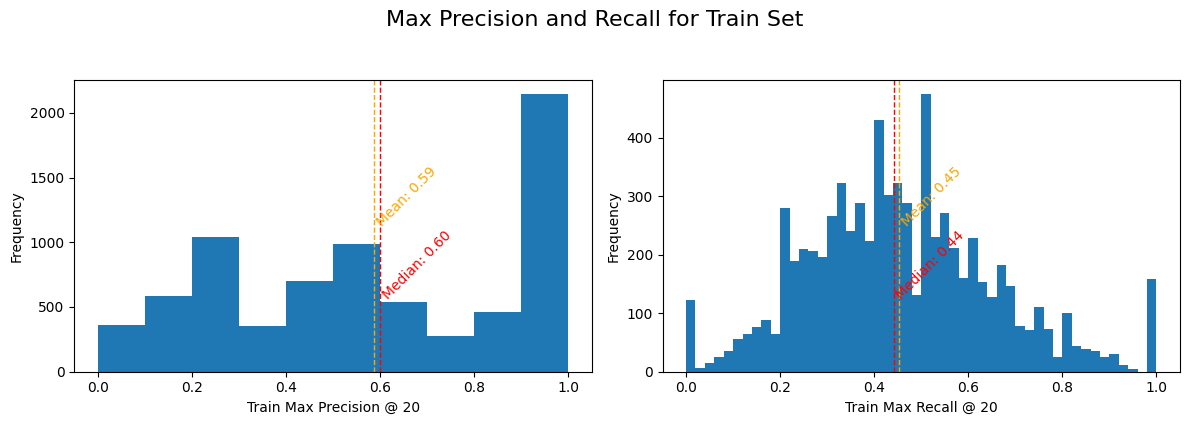

In [48]:
plot_precision_recall(dataset=train_dataset, top_k=20, name='Train', bins_list=[10, 50])

140296 pairs added with 28471 positive pairs and 111825 negative pairs | +/- ratio = 0.25 | 0 papers did have references stored in metadata dict.


140594 pairs added with 28769 positive pairs and 111825 negative pairs | +/- ratio = 0.26 | 0 papers did have references stored in metadata dict.

46832 pairs added with 12691 positive pairs and 34141 negative pairs | +/- ratio = 0.37 | 0 papers did have references stored in metadata dict.


check_year = False: 50173 pairs added with 12902 positive pairs and 37271 negative pairs | +/- ratio = 0.35 | 0 papers did have references stored in metadata dict.\
check_year = True: 46875 pairs added with 12678 positive pairs and 34197 negative pairs | +/- ratio = 0.37 | 0 papers did have references stored in metadata dict.


This probably means that KNN neighbours don't have that many relevant references around them (perhaps because most references are not stored)

In [59]:
# aiayn_refs = metadata['7b54a851675cc73367cd28c296d393564ebe55f5']['references']
# aiayn_knn_1k = find_knn_pid('7b54a851675cc73367cd28c296d393564ebe55f5', knn_tree, embedding_map, metadata, all_pids, knn_k=5000)
# len(aiayn_refs), len(set(aiayn_refs) & set(aiayn_knn_1k))

In [60]:
# metadata['7b54a851675cc73367cd28c296d393564ebe55f5'], 9b61735315618a8c2dfafc41eb3c774371adacd3

In [49]:
val_dataset = PaperPairDataset(val_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='final_val_report')

In [120]:
val_dataset = PaperPairDatasetSkip(val_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='final_val_skip')

In [127]:
val_dataset = PaperPairDatasetOrdered(val_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='final_val_ordered')

In [131]:
val_dataset = PaperPairDatasetCustom(val_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='final_val_custom')

In [164]:
val_dataset = PaperPairDatasetCoC(val_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='final_val_coc')

  0%|          | 0/932 [00:00<?, ?it/s]

26582 pairs added with 13291 positive pairs and 13291 negative pairs | +/- ratio = 1.0 | 0 papers did have references stored in metadata dict.


In [ ]:
25592 pairs added with 12796 positive pairs and 12796 negative pairs | +/- ratio = 1.0 | 0 papers did have references stored in metadata dict.


In [51]:
len(PaperPairDataset(val_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='val_1k_base2').data)

TypeError: list indices must be integers or slices, not str

In [50]:
len(train_dataset)

208346

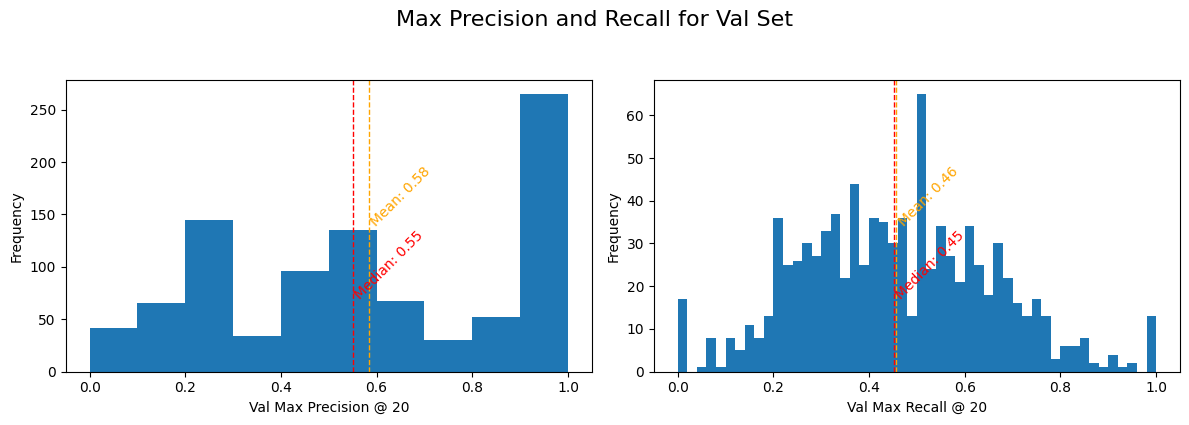

In [102]:
plot_precision_recall(dataset=val_dataset, top_k=20, name='Val', bins_list=[10, 50])

In [52]:
test_dataset = PaperPairDataset(test_paper_ids, embedding_map, reference_map, metadata, all_pids, knn_k=hparams['knn_k'], 
                               knn_tree=knn_tree, data_file='final_test_report')

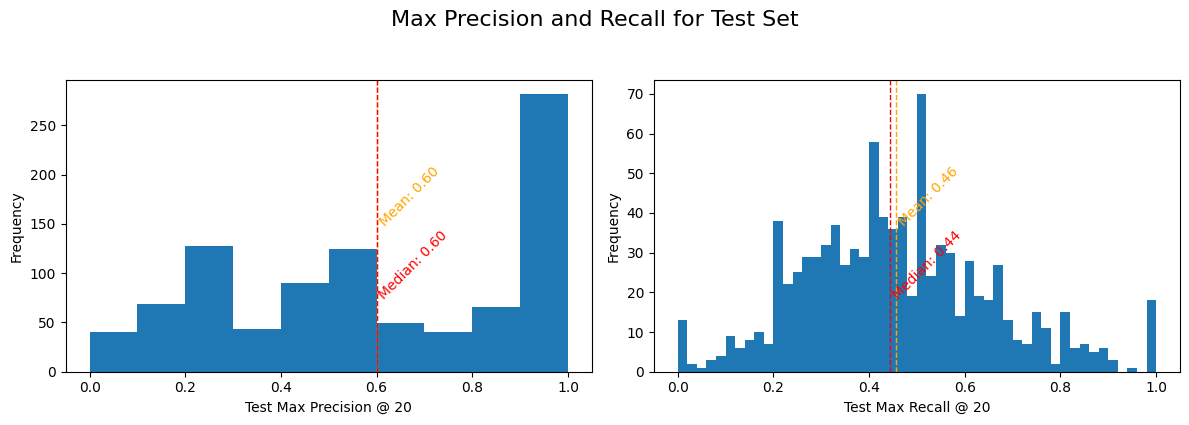

In [53]:
plot_precision_recall(dataset=test_dataset, top_k=20, name='Test', bins_list=[10, 50])

In [83]:
# test_max_precision = [min(val, hparams['top_k']) / hparams['top_k'] for val in test_dataset.max_refs_present]
# test_max_recall = [min(a, hparams['top_k'])/b for a,b in zip(test_dataset.max_refs_present, test_dataset.total_refs)]

In [84]:
# plot_stats(test_max_precision, xlabel=f'Train Max Precision @ {hparams["top_k"]} ', bins=10)

In [85]:
# plot_stats(test_max_recall, xlabel='Test Max Recall')

In [54]:
# %debug
# Verify data pairs are correctly labelled

def sanity_check(dataset):
    for qid, rid, label in dataset.data:
        qid_refs = set(metadata[qid]['references'])
        if label == 1: 
            assert(rid in qid_refs)
            continue
        assert(rid not in qid_refs)
    print('All Good')

In [55]:
sanity_check(train_dataset)
sanity_check(val_dataset)
sanity_check(test_dataset)

All Good
All Good
All Good


In [56]:
len(train_dataset), len(val_dataset)

(208346, 25540)

In [98]:
val_max_precision = [a/ hparams['top_k'] for a in val_dataset.max_refs_present]
val_max_recall = [min(a, hparams['top_k'])/b for a,b in zip(val_dataset.max_refs_present, val_dataset.total_refs)]

In [102]:
# plot_stats(val_max_precision, xlabel='Val Max Precision')

In [217]:
# # Storing the data in order to not have to recompute KNN pairs again
# with open(f'prepared_train_dataset_k{hparams['knn_k']}.pkl', 'wb') as f:
#     dill.dump(train_dataset, f)

In [196]:
# # Storing the data in order to not have to recompute KNN pairs again
# with open(f'prepared_val_dataset_k{hparams["knn_k"]}.pkl', 'wb') as f:
#     pickle.dump(val_dataset, f)

In [218]:
# # If I need to load dataset
# with open('prepared_dataset_k100.pkl', 'rb') as f:
#     temp_dataset = dill.load(f)

In [ ]:
## 22nd April
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2, dropout_prob=0.3, weight_decay=0.01):
        
#         super(PaperPairModel, self).__init__()
#         self.fc_layers = nn.ModuleList()
#         self.fc_layers.append(nn.Linear(embedding_dim * 2, hidden_dim))
#         for i in range(num_hidden_layers - 1):
#             self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout_prob)
#         self.fc_out = nn.Linear(hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid()
#         self.weight_decay = weight_decay

#     def forward(self, x1, x2):
#         x = torch.cat((x1, x2), dim=1)
#         for layer in self.fc_layers:
#             x = layer(x)
#             x = self.relu(x)
#             x = self.dropout(x)
#         x = self.fc_out(x)
#         x = self.sigmoid(x)
#         return x.squeeze()

#     def l2_regularization_loss(self):
#         l2_loss = 0.0
#         for param in self.parameters():
#             l2_loss += torch.norm(param, p=2)**2
#         return self.weight_decay * l2_loss

#     def loss(self, outputs, targets):
#         bce_loss = nn.BCELoss()(outputs, targets)
#         l2_loss = self.l2_regularization_loss()
#         return bce_loss + l2_loss

In [ ]:
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2):
        
#         super(PaperPairModel, self).__init__()
#         self.fc_layers = nn.ModuleList()
#         self.fc_layers.append(nn.Linear(embedding_dim * 2, hidden_dim))
#         for i in range(num_hidden_layers - 1):
#             self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
#         self.relu = nn.ReLU()
#         self.fc_out = nn.Linear(hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x1, x2):
#         # print(x1.shape, x2. shape)
#         x = torch.cat((x1, x2), dim=1)
#         for layer in self.fc_layers:
#             x = layer(x)
#             x = self.relu(x)
#         x = self.fc_out(x)
#         x = self.sigmoid(x)
#         return x.squeeze()


In [ ]:
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=256):
        
#         super(PaperPairModel, self).__init__()
#         self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x1, x2):
#         # print(x1.shape, x2. shape)
#         x = torch.cat((x1, x2), dim=1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x.squeeze()

In [45]:
# # %debug
# train_dataset = PaperPairDataset(train_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids)
# val_dataset = PaperPairDataset(val_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids)
# test_dataset = PaperPairDataset(test_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids)

In [349]:
# 1/train_dataset.pos_neg_ratio, # pos_weight = 1/train_dataset.pos_neg_ratio

In [53]:
study.best_params

NameError: name 'study' is not defined

In [57]:
hparams = {
    'batch_size': 2048,
    # 'hidden_dim': 768,
    # 'num_hidden_layers': 3,
    'hidden_dims': [1024, 2048],
    'lr': 1e-2,
    'min_lr': 1e-7,
    'patience': 3,
    'factor': 0.1,
    'num_epochs': 250,
    'weight_decay': 1e-3,
    'dropout_prob': 0.5,
    'stop_after': 5, # does NOT work, need to fix
    'knn_k': 1000, # for getting nearest neighbours
    'top_k': 20, # for evaluation
    'use_bn': True,
    'bn_momentum': 0.9
}

During experimentation lr=1e-2 seems like the best place to start. 0.1 is too bad

TanH seems to be better than RELU, LeakyRELU

Weight Decay 1e-3 seems best. WD >=1 just kills training as weights appoach 0

More than 4 layers seems bad. Need to verify

Dropout seems to be required as it overfits quite a bit otherwise. 0.5 seems good



In [59]:
class PaperPairModel(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dims=None, dropout_prob=0.3, weight_decay=0.01, use_bn=True, bn_momentum=0.9):
        super(PaperPairModel, self).__init__()
        input_dim = embedding_dim * 2 + 2
        layers = [nn.Linear(input_dim, hidden_dims[0])]
        if use_bn:
            layers.append(nn.BatchNorm1d(hidden_dims[0], momentum=bn_momentum))
        layers.extend([nn.Tanh(), nn.Dropout(dropout_prob)])

        for i in range(1, len(hidden_dims)):
            layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dims[i], momentum=bn_momentum))
            layers.extend([nn.Tanh(), nn.Dropout(dropout_prob)])

        layers.extend([nn.Linear(hidden_dims[-1], 1)])#, nn.Sigmoid()])
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x1, x2, is_after):
        cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8).unsqueeze(1)
        x_diff = torch.abs(x1 - x2)
        x_mul = x1 * x2
        x = torch.cat((x_diff, x_mul, is_after.unsqueeze(1), cosine_sim), dim=1)
        
        x = self.fc_layers(x)
        return x.squeeze()


In [61]:
# hparams = {
#     'batch_size': 2048,
#     'hidden_dims': [1024, 2048],
#     'lr': 1e-2,
#     'min_lr': 1e-7,
#     'patience': 3,
#     'factor': 0.1,
#     'num_epochs': 250,
#     'weight_decay': 1e-3,
#     'dropout_prob': 0.5,
#     'stop_after': 5, 
#     'knn_k': 1000, # for getting nearest neighbours
#     'top_k': 20, # for evaluation
#     'use_bn': True,
#     'bn_momentum': 0.9,
#     'num_epochs': 50
# }

In [60]:
hparams = {
    'batch_size': 2048,
    'hidden_dims': [1024, 2048],
    'lr': 1e-2,
    'min_lr': 1e-7,
    'patience': 3,
    'factor': 0.1,
    'weight_decay': 1e-3,
    'dropout_prob': 0.5,
    'stop_after': 5, 
    'knn_k': 1000, # for getting nearest neighbours
    'top_k': 20, # for evaluation
    'use_bn': True,
    'bn_momentum': 0.9,
    'num_epochs': 30
}

In [61]:
train_dataloader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

# model = PaperPairModel(hidden_dim=hparams['hidden_dim'], num_hidden_layers = hparams['num_hidden_layers'], dropout_prob = hparams['dropout_prob'], use_bn=hparams['use_bn'], 
#                       bn_momentum=hparams['bn_momentum'])
model = PaperPairModel(hidden_dims=hparams['hidden_dims'], dropout_prob = hparams['dropout_prob'], use_bn=hparams['use_bn'], 
                      bn_momentum=hparams['bn_momentum'])


print(model)
model.to(DEVICE)
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=hparams['lr'], weight_decay = hparams['weight_decay'])

# Initialize the learning rate scheduler with early stopping
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=hparams['factor'], 
                                                          patience=hparams['patience'], verbose=True, min_lr=hparams['min_lr'])


train_losses = []
val_losses = []

PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2048, out_features=1, bias=True)
  )
)


In [92]:
# aiayn_refs = metadata[test_paper_id]['references']
# aiayn_knn_1k = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=1000)
# len(aiayn_refs), len(set(aiayn_refs) & set(find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=1000)))

In [93]:
# 27/37, 20/27

In [66]:
# Train the model
DEBUG = False
num_epochs = hparams['num_epochs']
best_val_loss = float('inf')
test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0

    for data in train_dataloader:
        embeddings1, embeddings2, labels, is_after = data
        # embeddings1, embeddings2, labels = data
        embeddings1 = embeddings1.to(DEVICE)
        embeddings2 = embeddings2.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        is_after = is_after.to(DEVICE)
        
        outputs = model(embeddings1, embeddings2, is_after)
        # outputs = model(embeddings1, embeddings2)
        train_loss = criterion(outputs, labels)
        # train_loss = model.loss(outputs, labels)
        train_loss.backward()
        optimizer.step()

        running_loss += train_loss.item()
        
        
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Get val_loss from val set
    model.eval()
    with torch.no_grad():
        for data in val_dataloader:
            embeddings1, embeddings2, labels, is_after = data
            # embeddings1, embeddings2, labels = data
            
            embeddings1 = embeddings1.to(DEVICE)
            embeddings2 = embeddings2.to(DEVICE)
            labels = labels.to(DEVICE)
            is_after = is_after.to(DEVICE)
            
            outputs = model(embeddings1, embeddings2, is_after)
            # outputs = model(embeddings1, embeddings2)
            val_loss = criterion(outputs, labels)
            # val_loss = model.loss(outputs, labels)
            running_val_loss += val_loss.item()
            
    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)
    
    # Evaluate model on AIAYN paper for monitoring
    model_rec_ids = get_recommendations(model, test_paper_id, knn_tree, embedding_map, metadata, all_pids, top_k = hparams['top_k'], knn_k=hparams['knn_k'])
    precision, recall, f1_score = evaluate(model_rec_ids, actual_references, top_k=hparams['top_k'])
    model.train()
    
    if num_epochs > 100:
        if (epoch + 1 ) % 10 == 0:
            print(f'Epoch {epoch + 1}: train_loss={train_loss:.5f}, val_loss={val_loss:.5f}, [AIAYN: p@{hparams["top_k"]}={precision:.2f}, r@{hparams["top_k"]}={recall:.2f}, f1@{hparams["top_k"]}={f1_score:.2f}]')
    else:
        # print(f'Epoch {epoch + 1}: train_loss={train_loss}, val_loss={val_loss}')
        print(f'Epoch {epoch + 1}: train_loss={train_loss:.5f}, val_loss={val_loss:.5f}, [AIAYN: p@{hparams["top_k"]}={precision:.2f}, r@{hparams["top_k"]}={recall:.2f}, f1@{hparams["top_k"]}={f1_score:.2f}]')
        
        

    # Update the learning rate scheduler and check for early stopping
    lr_scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model checkpoint
        torch.save(model.state_dict(), "best_model.pth")
    else:
        # Stop the training if the validation loss does not improve for 5 consecutive epochs
        if lr_scheduler.num_bad_epochs == hparams['stop_after']:
            print("Early stopping")
            # torch.save(model.state_dict(), "best_model.pth")
            break

            
precision, recall = evaluate_model(model, test_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids, 
                                   top_k=hparams['top_k'], knn_k = hparams['knn_k'])
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

Epoch 1: train_loss=0.46638, val_loss=0.44342, [AIAYN: p@20=0.25, r@20=0.14, f1@20=0.18]
Epoch 2: train_loss=0.43847, val_loss=0.45338, [AIAYN: p@20=0.35, r@20=0.19, f1@20=0.25]
Epoch 3: train_loss=0.40691, val_loss=0.39973, [AIAYN: p@20=0.25, r@20=0.14, f1@20=0.18]
Epoch 4: train_loss=0.37585, val_loss=0.37308, [AIAYN: p@20=0.25, r@20=0.14, f1@20=0.18]
Epoch 5: train_loss=0.35029, val_loss=0.35513, [AIAYN: p@20=0.15, r@20=0.08, f1@20=0.11]
Epoch 6: train_loss=0.32180, val_loss=0.34604, [AIAYN: p@20=0.20, r@20=0.11, f1@20=0.14]
Epoch 7: train_loss=0.29901, val_loss=0.32466, [AIAYN: p@20=0.25, r@20=0.14, f1@20=0.18]
Epoch 8: train_loss=0.27720, val_loss=0.33373, [AIAYN: p@20=0.30, r@20=0.16, f1@20=0.21]
Epoch 9: train_loss=0.26214, val_loss=0.31924, [AIAYN: p@20=0.30, r@20=0.16, f1@20=0.21]
Epoch 10: train_loss=0.24535, val_loss=0.31089, [AIAYN: p@20=0.30, r@20=0.16, f1@20=0.21]
Epoch 11: train_loss=0.23307, val_loss=0.31684, [AIAYN: p@20=0.30, r@20=0.16, f1@20=0.21]
Epoch 12: train_los

  0%|          | 0/932 [00:00<?, ?it/s]

Precision @ 20: 0.19291845493562226
Recall @ 20: 0.16685032338031597


In [67]:
precision, recall = evaluate_model(model, val_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids, 
                                   top_k=hparams['top_k'], knn_k = hparams['knn_k'])
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2048, out_features=1, bias=True)
  )
)


  0%|          | 0/932 [00:00<?, ?it/s]

Precision @ 20: 0.1987660944206009
Recall @ 20: 0.1733432109452088


In [68]:
precision, recall = evaluate_model(model, train_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids, 
                                   top_k=hparams['top_k'], knn_k = hparams['knn_k'])
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2048, out_features=1, bias=True)
  )
)


  0%|          | 0/7455 [00:00<?, ?it/s]

Precision @ 20: 0.19467471495640334
Recall @ 20: 0.16438802142270634


In [47]:
best_val_loss

0.31775221687096816

In [ ]:
# Without BN: Epoch 50: train_loss=0.42974, val_loss=0.52383, [AIAYN: p@20=0.35, r@20=0.19, f1@20=0.25]
# With BN Epoch 9: train_loss=0.42943, val_loss=0.51953, [AIAYN: p@20=0.45, r@20=0.24, f1@20=0.32]
# Epoch 22: train_loss=0.38933, val_loss=0.51304, [AIAYN: p@20=0.45, r@20=0.24, f1@20=0.32]

# Conclusion: BN needed

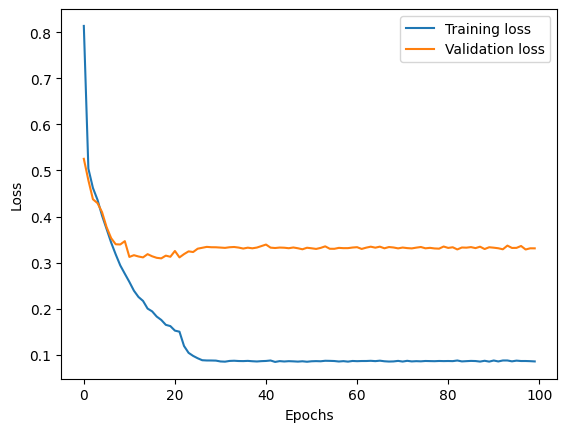

In [76]:
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
2 hidden layers ~600 epochs
Epoch 500: train_loss=0.2624791022830122, val_loss=0.30308062583208084

3 hidden layers 100 epochs
Epoch 100: train_loss=0.30075453409529107, val_loss=0.32325271610170603

--------------------------------------------------------------------------------

BETTER TRAINING DATA (including previous years as 0)
2 hidden layers 
Epoch 100: train_loss=0.1777532718477458, val_loss=0.1910507024990188
Epoch 270: train_loss=0.16910822787424074, val_loss=0.18511556006140178

## Hyperparameter Search

In [263]:
# from optuna.pruners import MedianPruner

# def objective(trial):
#     hidden_dim = trial.suggest_int("hidden_dim", 512, 4096, step=512)
#     num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5, step=1)
#     # lr = trial.suggest_categorical("lr", [1e-4, 1e-3])  
#     lr = 1e-4
#     weight_decay = trial.suggest_categorical("weight_decay", [1e-4, 1e-3, 1e-2, 1e-1, 1])
#     dropout_prob = trial.suggest_categorical("dropout_prob", [0.1, 0.2, 0.3, 0.4, 0.5])
#     num_epochs = 20
#     model = PaperPairModel(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers, dropout_prob=dropout_prob)
#     model.to(DEVICE)
#     criterion = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=hparams['factor'],
#                                                               patience=hparams['patience'], verbose=True)
#     best_val_loss = float('inf')
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         running_val_loss = 0.0


#         for i, data in enumerate(train_dataloader):
#             embeddings1, embeddings2, labels, is_after = data
#             embeddings1 = embeddings1.to(DEVICE)
#             embeddings2 = embeddings2.to(DEVICE)
#             labels = labels.to(DEVICE)
#             optimizer.zero_grad()
#             is_after = is_after.to(DEVICE)


#             outputs = model(embeddings1, embeddings2, is_after)
#             loss = criterion(outputs, labels)
#             # loss = model.loss(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         train_loss = running_loss / len(train_dataloader)

#         model.eval()
#         with torch.no_grad():
#             for i, data in enumerate(val_dataloader):
#                 embeddings1, embeddings2, labels, is_after = data
#                 embeddings1 = embeddings1.to(DEVICE)
#                 embeddings2 = embeddings2.to(DEVICE)
#                 labels = labels.to(DEVICE)
#                 is_after = is_after.to(DEVICE)

#                 outputs = model(embeddings1, embeddings2, is_after)
#                 val_loss = criterion(outputs, labels)
#                 # val_loss = model.loss(outputs, labels)

#                 running_val_loss += val_loss.item()


#         val_loss = running_val_loss / len(val_dataloader)
#          # Report intermediate result for pruning
#         trial.report(val_loss, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()


#         model.train()


#         # Update the learning rate scheduler and check for early stopping
#         lr_scheduler.step(val_loss)
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             # Save the best model checkpoint
#             torch.save(model.state_dict(), "best_model.pth")
#         else:
#             # Stop the training if the validation loss does not improve for 5 consecutive epochs
#             if lr_scheduler.num_bad_epochs == hparams['stop_after']:
#                 print("Early stopping")
#                 torch.save(model.state_dict(), "best_model.pth")
#                 break

#     return best_val_loss



# study = optuna.create_study(direction="minimize", pruner=MedianPruner())
# study.optimize(objective, n_trials=50)


# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")


In [50]:
import optuna
from optuna.pruners import MedianPruner
import itertools

In [51]:
hparams = {
    'batch_size': 4096,
    # 'hidden_dim': 768,
    # 'num_hidden_layers': 3,
    'hidden_dims': [1024, 2048],
    'lr': 1e-2,
    'min_lr': 1e-7,
    'patience': 3,
    'factor': 0.1,
    'num_epochs': 250,
    'weight_decay': 1e-3,
    'dropout_prob': 0.5,
    'stop_after': 5, # does NOT work, need to fix
    'knn_k': 1000, # for getting nearest neighbours
    'top_k': 20, # for evaluation
    'use_bn': True,
    'bn_momentum': 0.9
}

In [68]:
def objective(trial):
    # Suggest values of the hyperparameters using a trial object

    weight_decay = trial.suggest_categorical("weight_decay", [1e-4, 1e-3, 1e-2])
    dropout_prob = trial.suggest_categorical("dropout_prob", [0.1, 0.3, 0.5, 0.7, 0.9])
    bn_momentum = trial.suggest_categorical("bn_momentum", [0.1, 0.3, 0.5, 0.7, 0.9])
    

    hidden_dims_options = [256, 512, 768, 1024, 1536]
    hidden_dims = []
    hidden_dims_length = trial.suggest_int("hidden_dims_length", 1, 3)
    for i in range(hidden_dims_length):
        hidden_dim = trial.suggest_categorical(f"hidden_dim_{i+1}", hidden_dims_options)
        hidden_dims.append(hidden_dim)



    hparams = {
        'batch_size': 4096,
        'dropout_prob': dropout_prob,
        'weight_decay': weight_decay,
        'hidden_dims': hidden_dims,
        'bn_momentum': bn_momentum,
        'use_bn': True,
        'lr': 1e-2,
        'min_lr': 1e-7,
        'patience': 3,
        'factor': 0.1,
        'stop_after': 5, # does NOT work, need to fix
        'knn_k': 1000, # for getting nearest neighbours
        'top_k': 20, # for evaluation
        'use_bn': True,
        'num_epochs': 30
        
    }

    # Modify your train_and_evaluate_model function to accept the hparams dictionary
    val_loss = train_and_evaluate_model(hparams, trial)

    return val_loss


In [75]:
def train_and_evaluate_model(hparams, trial):
    # Create model with given hyperparameters
    model = PaperPairModel(hidden_dims=hparams['hidden_dims'], dropout_prob=hparams['dropout_prob'], use_bn=hparams['use_bn'], 
                          bn_momentum=hparams['bn_momentum'])
    model.to(DEVICE)
    # print(model)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=hparams['factor'], 
                                                              patience=hparams['patience'], verbose=True, min_lr=hparams['min_lr'])

    best_val_loss = float('inf')
    num_epochs = hparams['num_epochs']
    pbar = tqdm(total=num_epochs, desc='Training', unit='epoch')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        
        for data in train_dataloader:
            embeddings1, embeddings2, labels, is_after = data
            # embeddings1, embeddings2, labels = data
            embeddings1 = embeddings1.to(DEVICE)
            embeddings2 = embeddings2.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            is_after = is_after.to(DEVICE)

            outputs = model(embeddings1, embeddings2, is_after)
            # outputs = model(embeddings1, embeddings2)
            train_loss = criterion(outputs, labels)
            # train_loss = model.loss(outputs, labels)
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # Get val_loss from val set
        model.eval()
        with torch.no_grad():
            for data in val_dataloader:
                embeddings1, embeddings2, labels, is_after = data
                # embeddings1, embeddings2, labels = data

                embeddings1 = embeddings1.to(DEVICE)
                embeddings2 = embeddings2.to(DEVICE)
                labels = labels.to(DEVICE)
                is_after = is_after.to(DEVICE)

                outputs = model(embeddings1, embeddings2, is_after)
                # outputs = model(embeddings1, embeddings2)
                val_loss = criterion(outputs, labels)
                # val_loss = model.loss(outputs, labels)
                running_val_loss += val_loss.item()

        val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(val_loss)
        lr_scheduler.step(val_loss)
        
        # print(f'Epoch {epoch + 1}: train_loss={train_loss:.5f}, val_loss={val_loss:.5f}')
        pbar.update(1)
        # pbar.set_description(f'Training [Epoch {epoch+1}/{num_epochs}]')
        pbar.set_description(f'Trial {trial.number}')
        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss)



        # Report intermediate value (validation loss) to the trial
        trial.report(val_loss, epoch)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()

    pbar.close()
    return val_loss


In [74]:
# def print_trial_result(study, trial):
#     print(f"Trial {trial.number}: {trial.value:.5f}, best so far: {study.best_value:.5f}")


In [60]:
def save_best_trial_params(study, trial):
    if study.best_trial.number == trial.number:
        best_hparams = {
            'dropout_prob': trial.params['dropout_prob'],
            'weight_decay': trial.params['weight_decay'],
            'bn_momentum': trial.params['bn_momentum'],
            'hidden_dims_length': trial.params['hidden_dims_length'],
            'hidden_dims': [trial.params[f"hidden_dim_{i+1}"] for i in range(trial.params['hidden_dims_length'])],
            'val_loss': trial.value
        }

        with open('best_hparams.json', 'w') as f:
            json.dump(best_hparams, f, indent=4)

        print(f"Saved best hparams from trial {trial.number}: {best_hparams}")

In [63]:
pruned_trials = study.get_trials(states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(states=[optuna.trial.TrialState.COMPLETE])
print("# Pruned trials: ", len(pruned_trials))
print("# Complete trials: ", len(complete_trials))
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))


Trial 19:  30%|███       | 6/20 [04:12<09:48, 42.02s/epoch, train_loss=0.453, val_loss=0.432]

# Pruned trials:  14
# Complete trials:  6
Best Score:  0.29735722712108065
Best Params: 
  hidden_dims_length: 3
  hidden_dim_1: 1536
  hidden_dim_2: 1024
  hidden_dim_3: 1024


In [ ]:
Pruned trials:  14
Complete trials:  6
Best Score:  0.29735722712108065
Best Params: 
  hidden_dims_length: 3
  hidden_dim_1: 1536
  hidden_dim_2: 1024
  hidden_dim_3: 1024

In [72]:
pruner = MedianPruner(n_startup_trials=3, n_warmup_steps=10)

# Create study
study = optuna.create_study(direction='minimize', pruner=pruner)

[I 2023-05-07 11:41:10,903] A new study created in memory with name: no-name-c8f7e228-e933-4ae2-bd83-11deee22d6b6


In [73]:
study.optimize(objective, n_trials=20, callbacks=[save_best_trial_params])

PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.9, inplace=False)
    (4): Linear(in_features=512, out_features=768, bias=True)
    (5): BatchNorm1d(768, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.9, inplace=False)
    (8): Linear(in_features=768, out_features=1536, bias=True)
    (9): BatchNorm1d(1536, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.9, inplace=False)
    (12): Linear(in_features=1536, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 11:44:37,705] Trial 0 finished with value: 0.4362166864531381 and parameters: {'weight_decay': 0.001, 'dropout_prob': 0.9, 'bn_momentum': 0.3, 'hidden_dims_length': 3, 'hidden_dim_1': 512, 'hidden_dim_2': 768, 'hidden_dim_3': 1536}. Best is trial 0 with value: 0.4362166864531381.


Trial 0: 0.43622, best so far: 0.43622
Saved best hparams from trial 0: {'hidden_dims_length': 3, 'hidden_dims': [512, 768, 1536], 'val_loss': 0.4362166864531381}
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00020: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00028: reducing learning rate of group 0 to 1.0000e-05.


[I 2023-05-07 11:47:56,152] Trial 1 finished with value: 0.3333750367164612 and parameters: {'weight_decay': 0.001, 'dropout_prob': 0.3, 'bn_momentum': 0.5, 'hidden_dims_length': 1, 'hidden_dim_1': 1024}. Best is trial 1 with value: 0.3333750367164612.


Trial 1: 0.33338, best so far: 0.33338
Saved best hparams from trial 1: {'hidden_dims_length': 1, 'hidden_dims': [1024], 'val_loss': 0.3333750367164612}
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-05-07 11:51:12,407] Trial 2 finished with value: 0.3140972639833178 and parameters: {'weight_decay': 0.001, 'dropout_prob': 0.5, 'bn_momentum': 0.3, 'hidden_dims_length': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 512}. Best is trial 2 with value: 0.3140972639833178.


Trial 2: 0.31410, best so far: 0.31410
Saved best hparams from trial 2: {'hidden_dims_length': 2, 'hidden_dims': [512, 512], 'val_loss': 0.3140972639833178}
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1536, bias=True)
    (1): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1536, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.


[I 2023-05-07 11:52:36,590] Trial 3 pruned. 


Trial 3: 0.39009, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 11:53:48,725] Trial 4 pruned. 


Trial 4: 0.36408, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.9, inplace=False)
    (4): Linear(in_features=256, out_features=768, bias=True)
    (5): BatchNorm1d(768, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.9, inplace=False)
    (8): Linear(in_features=768, out_features=768, bias=True)
    (9): BatchNorm1d(768, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.9, inplace=False)
    (12): Linear(in_features=768, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 11:55:01,092] Trial 5 pruned. 


Trial 5: 0.47629, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=768, out_features=1536, bias=True)
    (5): BatchNorm1d(1536, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1536, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.


[I 2023-05-07 11:58:25,693] Trial 6 finished with value: 0.3168013436453683 and parameters: {'weight_decay': 0.0001, 'dropout_prob': 0.5, 'bn_momentum': 0.7, 'hidden_dims_length': 2, 'hidden_dim_1': 768, 'hidden_dim_2': 1536}. Best is trial 2 with value: 0.3140972639833178.


Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.
Trial 6: 0.31680, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.9, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.9, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.9, inplace=False)
    (12): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 11:59:42,184] Trial 7 pruned. 


Trial 7: 0.45725, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:00:54,762] Trial 8 pruned. 


Trial 8: 0.35950, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:02:22,262] Trial 9 pruned. 


Trial 9: 0.33749, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:03:35,386] Trial 10 pruned. 


Trial 10: 0.41920, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=768, out_features=1536, bias=True)
    (5): BatchNorm1d(1536, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1536, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:05:04,884] Trial 11 pruned. 


Trial 11: 0.33595, best so far: 0.31410
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=768, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-05-07 12:08:25,144] Trial 12 finished with value: 0.3086707762309483 and parameters: {'weight_decay': 0.0001, 'dropout_prob': 0.5, 'bn_momentum': 0.7, 'hidden_dims_length': 2, 'hidden_dim_1': 768, 'hidden_dim_2': 256}. Best is trial 12 with value: 0.3086707762309483.


Trial 12: 0.30867, best so far: 0.30867
Saved best hparams from trial 12: {'hidden_dims_length': 2, 'hidden_dims': [768, 256], 'val_loss': 0.3086707762309483}
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=768, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00015: reducing learning rate of group 0 to 1.0000e-03.


[I 2023-05-07 12:10:31,498] Trial 13 pruned. 


Trial 13: 0.33944, best so far: 0.30867
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1536, bias=True)
    (1): BatchNorm1d(1536, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1536, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.


[I 2023-05-07 12:11:45,275] Trial 14 pruned. 


Trial 14: 0.37172, best so far: 0.30867
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=768, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:12:56,894] Trial 15 pruned. 


Trial 15: 0.36293, best so far: 0.30867
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=768, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00027: reducing learning rate of group 0 to 1.0000e-05.


[I 2023-05-07 12:16:14,402] Trial 16 finished with value: 0.3015765632901873 and parameters: {'weight_decay': 0.001, 'dropout_prob': 0.5, 'bn_momentum': 0.3, 'hidden_dims_length': 2, 'hidden_dim_1': 768, 'hidden_dim_2': 256}. Best is trial 16 with value: 0.3015765632901873.


Trial 16: 0.30158, best so far: 0.30158
Saved best hparams from trial 16: {'hidden_dims_length': 2, 'hidden_dims': [768, 256], 'val_loss': 0.3015765632901873}
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=768, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:17:39,003] Trial 17 pruned. 


Trial 17: 0.33427, best so far: 0.30158
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=768, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 00021: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00025: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-05.


[I 2023-05-07 12:21:01,595] Trial 18 finished with value: 0.30859442693846567 and parameters: {'weight_decay': 0.0001, 'dropout_prob': 0.5, 'bn_momentum': 0.9, 'hidden_dims_length': 2, 'hidden_dim_1': 768, 'hidden_dim_2': 256}. Best is trial 16 with value: 0.3015765632901873.


Trial 18: 0.30859, best so far: 0.30158
PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=768, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=256, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.7, inplace=False)
    (12): Linear(in_features=1024, out_features=1, bias=True)
  )
)


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

[I 2023-05-07 12:22:15,167] Trial 19 pruned. 


Trial 19: 0.36353, best so far: 0.30158


In [55]:
# ## TESTING FOR AIAYN PAPER INDIVUDALLY FOR DEBUGGING
# paper_embedding = get_embedding(metadata[test_paper_id], embedding_map)
# # top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=knn_k, least=False)
# # recommended_paper_ids = [all_paper_ids[i] for i in top_indices]
# recommended_paper_ids = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=hparams['knn_k'])
# # find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=k)
# other_paper_embeddings = torch.stack([embedding_map[pid] for pid in recommended_paper_ids])
# # Get years from metadata and create is_after tensor
# paper_year = metadata[paper_id]['year']
# other_paper_years = [metadata[pid]['year'] for pid in recommended_paper_ids]
# is_after = torch.tensor([int(paper_year < other_year) for other_year in other_paper_years], dtype=torch.float32).to(DEVICE)
# with torch.no_grad():
#         paper_embedding = paper_embedding.expand_as(other_paper_embeddings).to(DEVICE)
#         other_paper_embeddings = other_paper_embeddings.to(DEVICE)
#         scores = model(paper_embedding, other_paper_embeddings, is_after)
# model.train()
# top_k_indices = torch.topk(scores, k=hparams['top_k']).indices
# reranked_pids = [recommended_paper_ids[idx] for idx in top_k_indices]

# # [p for p in PaperPairDataset([test_paper_id], embedding_map, reference_map, metadata, all_pids, use_knn=True, knn_k=1000, 
# #                                knn_tree=knn_tree, num_positives=hparams['num_positives'], num_negatives=hparams['num_negatives']).data if p[2] == 1]

# aiayn_refs = metadata[test_paper_id]['references']
# aiayn_knn_1k = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=1000)
# len(aiayn_refs), len(set(aiayn_refs) & set(find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=1000)))



# aiayn_ref_indices_1k = [i for i, rec in enumerate(aiayn_knn_1k) if rec in set(aiayn_refs)]

# # aiayn_ref_indices_1k

# # aiayn_knn_1k[305]

# # recommended_paper_ids[305], scores[305]

# # top_k_indices

In [56]:
# Query Paper: Attention is All you Need
# top_k_indices

In [57]:
# Query paper year: 2017
# torch.tensor([metadata[rec_id]['year'] for rec_id in reranked_pids])

In [58]:
# Rerank score from the model for top_k_indices
# scores[top_k_indices]

In [59]:
# What scores of actual references is
# scores[aiayn_ref_indices_1k]

In [104]:
# def get_recommendations(model, paper_id, knn_tree, embedding_map, all_pids, top_k, knn_k):
#     model.eval()
#     paper_embedding = embedding_map[paper_id]
#     # other_paper_ids = [pid for pid in embedding_map if pid != paper_id]
#     # paper_embedding = get_embedding(metadata[paper_id], embedding_map)
#     # top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=knn_k, least=False)
#     # recommended_paper_ids = [all_paper_ids[i] for i in top_indices]
#     recommended_paper_ids = find_knn_pid(paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=knn_k)

#     other_paper_embeddings = torch.stack([embedding_map[pid] for pid in recommended_paper_ids])

#     with torch.no_grad():
#         paper_embedding = paper_embedding.expand_as(other_paper_embeddings).to(DEVICE)
#         other_paper_embeddings = other_paper_embeddings.to(DEVICE)
#         scores = model(paper_embedding, other_paper_embeddings)
#     model.train()
#     top_k_indices = torch.topk(scores, k=top_k).indices
#     reranked_pids = [recommended_paper_ids[idx] for idx in top_k_indices]
#     return reranked_pids

In [63]:
def get_recommendations(model, paper_id, knn_tree, embedding_map, metadata, all_pids, top_k, knn_k):
    model.eval()
    
    paper_embedding = embedding_map[paper_id]
    recommended_paper_ids = find_knn_pid(paper_id, knn_tree, embedding_map, metadata, all_pids, knn_k=knn_k)

    other_paper_embeddings = torch.stack([embedding_map[pid] for pid in recommended_paper_ids])

    # Get years from metadata and create is_after tensor
    paper_year = metadata[paper_id]['year']
    other_paper_years = [metadata[pid]['year'] for pid in recommended_paper_ids]
    is_after = torch.tensor([int(paper_year < other_year) for other_year in other_paper_years], dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        paper_embedding = paper_embedding.expand_as(other_paper_embeddings).to(DEVICE)
        other_paper_embeddings = other_paper_embeddings.to(DEVICE)
        # Pass the is_after tensor to the model
        scores = model(paper_embedding, other_paper_embeddings, is_after)
    scores = torch.sigmoid(scores)
    model.train()
    top_k_indices = torch.topk(scores, k=top_k).indices
    reranked_pids = [recommended_paper_ids[idx] for idx in top_k_indices]
    return reranked_pids

In [73]:
# %debug
test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
model_rec_ids = get_recommendations(model, test_paper_id, knn_tree, embedding_map, metadata, all_pids, top_k = hparams['top_k'], knn_k=hparams['knn_k'])

In [74]:
cnt = 0
for paper_id in model_rec_ids:
    title = metadata[paper_id]['title']
    # abstract = metadata[paper_id]['abstract']
    year = metadata[paper_id]['year']
    print(f'Paper ID: {paper_id}\nTitle: {title}\nYear: {year}')
    cnt += 1 
    if cnt == 20:
        break

Paper ID: 4ef03716945bd3907458efbe1bbf8928dafc1efc
Title: Regularization and nonlinearities for neural language models: when are they needed?
Year: 2013
Paper ID: 86151fd48b2578ac1232bd927e07a8815144496a
Title: Decoder Integration and Expected BLEU Training for Recurrent Neural Network Language Models
Year: 2014
Paper ID: 944a1cfd79dbfb6fef460360a0765ba790f4027a
Title: Recurrent Continuous Translation Models
Year: 2013
Paper ID: d76c07211479e233f7c6a6f32d5346c983c5598f
Title: Multi-task Sequence to Sequence Learning
Year: 2015
Paper ID: cea967b59209c6be22829699f05b8b1ac4dc092d
Title: Sequence to Sequence Learning with Neural Networks
Year: 2014
Paper ID: 43428880d75b3a14257c3ee9bda054e61eb869c0
Title: Convolutional Sequence to Sequence Learning
Year: 2017
Paper ID: 4f10b9f47c5bb6b54dd4f5ca8d9fa2c0bbd7ec5e
Title: End-To-End Memory Networks
Year: 2015
Paper ID: 1c4e9156ca07705531e45960b7a919dc473abb51
Title: Wide Residual Networks
Year: 2016
Paper ID: 44d2abe2175df8153f465f6c39b68b76a0d4

In [75]:
precision, recall, f1_score = evaluate(model_rec_ids, actual_references, top_k=hparams['top_k'])
print(f'For the Paper - {metadata[test_paper_id]["title"]}')
print(f"Precision @ {hparams['top_k']}: {precision}")
print(f"Recall @ {hparams['top_k']}: {recall}")
print(f"F1 Score: {f1_score}")

For the Paper - Attention is All you Need
Precision @ 20: 0.3
Recall @ 20: 0.16216216216216217
F1 Score: 0.2105263157894737


In [64]:
def evaluate_model(model, paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids, top_k, knn_k):
    '''
    model: The trained PaperPairModel, 
    paper_ids: the list of Paper IDs for the model to be evaluated on, 
    knn_tree: The k-NN tree created from the paper embeddings, 
    embedding_map: The dictionary mapping paper IDs to their embeddings, 
    reference_map: The dictionary mapping paper IDs to the list of IDs of their actual references,
    metadata: The dictionary containing metadata about each paper, 
    all_pids: The list of all paper IDs, 
    top_k: The number of top recommendations to return (IN THE ORDER OF all_pids), 
    knn_k: The number of nearest neighbours to consider in the k-NN tree, 
    '''
    print(model)
    precisions = []
    recalls = []
    for paper_id in tqdm(paper_ids):

        recommendations = set(get_recommendations(model, paper_id, knn_tree, embedding_map, metadata, all_pids, top_k=top_k, knn_k=knn_k))
        true_references = set(reference_map.get(paper_id, []))
        if not true_references:
            continue

        intersect = recommendations.intersection(true_references)
        precision = len(intersect) / len(recommendations)
        recall = len(intersect) / len(true_references)

        precisions.append(precision)
        recalls.append(recall)

    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    return mean_precision, mean_recall


In [59]:
# # Apparently test_model is not the best one out of the bunch!
test_model = PaperPairModel(hidden_dims=hparams['hidden_dims'], dropout_prob = hparams['dropout_prob'], use_bn=hparams['use_bn'], 
                      bn_momentum=hparams['bn_momentum'])
checkpoint_path = "best_model.pth"
test_model.load_state_dict(torch.load(checkpoint_path))
test_model.to(DEVICE)

PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [60]:
precision, recall = evaluate_model(test_model, test_paper_ids, knn_tree, embedding_map, reference_map, metadata, all_pids, 
                                   top_k=hparams['top_k'], knn_k = hparams['knn_k'])
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

PaperPairModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=1538, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2048, out_features=1, bias=True)
  )
)


  0%|          | 0/932 [00:00<?, ?it/s]

Precision @ 20: 0.1795600858369101
Recall @ 20: 0.1431251376302593


In [56]:
KNN BASELINE
Precision @ 20: 0.11979613733905542
Recall @ 20: 0.09537210096331365

Previous Best with the magic dataset
Precision @ 20: 0.1469957081545062
Recall @ 20: 0.12985076895866116


Current Best
Precision @ 20: 0.18766094420600862
Recall @ 20: 0.16728612574805324
With these hparams:
    hparams = {
    'batch_size': 4096,
    # 'hidden_dim': 768,
    # 'num_hidden_layers': 3,
    'hidden_dims': [768],
    'lr': 1e-2,
    'min_lr': 1e-7,
    'patience': 3,
    'factor': 0.1,
    'num_epochs': 250,
    'weight_decay': 1e-3,
    'dropout_prob': 0.5,
    'stop_after': 5, # does NOT work, need to fix
    'knn_k': 1000, # for getting nearest neighbours
    'top_k': 20, # for evaluation
    'use_bn': True,
    'bn_momentum': 0.1
}
And also BCEWithLogitsLoss


Precision @ 20: 0.19425965665236072
Recall @ 20: 0.16689689397325372
hparams = {
    'batch_size': 2048,
    # 'hidden_dim': 768,
    # 'num_hidden_layers': 3,
    'hidden_dims': [1024, 2048],
    'lr': 1e-2,
    'min_lr': 1e-7,
    'patience': 3,
    'factor': 0.1,
    'num_epochs': 250,
    'weight_decay': 1e-3,
    'dropout_prob': 0.5,
    'stop_after': 5, # does NOT work, need to fix
    'knn_k': 1000, # for getting nearest neighbours
    'top_k': 20, # for evaluation
    'use_bn': True,
    'bn_momentum': 0.9
}

SyntaxError: invalid syntax (4009781046.py, line 1)

In [60]:
def get_recommendations_new(model, title, abstract, knn_tree, embedding_map, metadata, all_pids, top_k, knn_k, return_scores=False):
    model.eval()
    paper_obj = {'title': title, 'abstract': abstract, 'year': 2023}
    print(paper_obj)
    # paper_embedding = embedding_map[paper_id]
    paper_embedding = get_embedding(paper_obj)
    top_indices, scores = find_knn(paper_embedding, knn_tree, knn_k=knn_k)
    recommended_paper_ids = [all_pids[i] for i in top_indices]

    other_paper_embeddings = torch.stack([embedding_map[pid] for pid in recommended_paper_ids])

    # Get years from metadata and create is_after tensor
    paper_year = paper_obj['year']
    other_paper_years = [metadata[pid]['year'] for pid in recommended_paper_ids]
    is_after = torch.tensor([int(paper_year < other_year) for other_year in other_paper_years], dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        paper_embedding = paper_embedding.expand_as(other_paper_embeddings).to(DEVICE)
        other_paper_embeddings = other_paper_embeddings.to(DEVICE)
        # Pass the is_after tensor to the model
        scores = model(paper_embedding, other_paper_embeddings, is_after)
    model.train()
    top_k = torch.topk(scores, k=top_k)
    # top_k_indices = torch.topk(scores, k=top_k).indices
    top_k_indices = top_k.indices
    top_k_scores = top_k.values
    reranked_pids = [recommended_paper_ids[idx] for idx in top_k_indices]
    if return_scores:
        return reranked_pids, top_k_scores
    return reranked_pids

In [79]:
reranked_pids

(['1321e0431d8e868334d77ba83f7e0c0b7863cb23',
  '5e352848c02c420cf420a157627403456a152c61',
  '5e17e0a6ef8f79eb524bec9e4ba3be0910046447',
  '1954a67069a6744cc6c85f258c430431118a9916',
  'c154bf5b586cd797adc24231a3c71a3bc4a012fb',
  '34d1174daea6d67624ba8213e4bda0606ee1b4c3',
  '53489041a08ef1a6cd19b4c95ce092a148283b6b',
  '0ecfe92f4dd4d04c729a04dca6a63081e72ccbf9',
  '28dd515fe25a5842002d43c9b8e26bf9093620fd',
  'dc3ccdedf86df2e7f155e948e1053749e23951e6',
  'b1764f91caa0d3359b263ad6daa6287b35a19697',
  'a9de6da6ed116b90fe3c396ce9493c0bd259c265',
  '6c9c55e896127a4c7469a95abfb12bab47ea902a',
  '0e6f0bf80df91f7a613b425dd8c0b73f85b44f3b',
  '2c0270f89f9559239112e79d9fa1aee2d58adaf7',
  '05d5a28fd29fdbd405743cd282888e463c8cb26a',
  'c421abb09a76f6032ac098840a8f1711199e83af',
  '23aec531c9245b3fbc93567faecf0a7a63431d94',
  '851332942f7cfbd74e3f2799309c1383fa547fb6',
  'd230862f33946a3572ff7df78bfc0aaa726cd787'],
 tensor([1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998

In [61]:
# test_model = PaperPairModel(hidden_dims=hparams['hidden_dims'], dropout_prob = hparams['dropout_prob'], use_bn=hparams['use_bn'], 
#                       bn_momentum=hparams['bn_momentum'])
# checkpoint_path = "best_model.pth"
# test_model.load_state_dict(torch.load(checkpoint_path))
# test_model.to(DEVICE)
reranked_pids = get_recommendations_new(model, new_title, new_abstract, knn_tree, embedding_map, metadata, all_pids, 1000, 1000)
for i, pid in enumerate(reranked_pids):
    title = metadata[pid]['title']
    # abstract = metadata[paper_id]['abstract']
    year = metadata[pid]['year']
    print(f'Paper ID: {pid}\nTitle: {title}\nYear: {year}')# \nCosine similarity: {cos_sim}\n')
    if 'SPECTER' in title:
        print(i)
    if i == 100:
        break

{'title': 'Refpred - A Research Paper Recommendation System based on SPECTER', 'abstract': 'The literature review is an essential part of the research process, as it helps researchers understand the current state of knowledge in their field and identify gaps that their own research can address. However, the current review process with manual paper searching, can be time-consuming and labour-intensive. This is particularly true for researchers working in fields with large and rapidly-growing bodies of literature such as Medicine or Machine Learning. To tackle this issue, we aim to build RefPred - a system that uses a citation-informed transformer with a recommendation engine to recommend relevant papers to assist researchers in review process. Specifically, given a new title/abstract, it should be able to predict the most relevant papers and sort them according to some metric (such as citation count or similarity score). For doing this, we create a dataset comprising of thousands of res

KNN Baseline (100k KNN tree)\
Precision @ 20: 0.12178111587982793\
Recall @ 20: 0.10163559712988064\

10 08

KNN baseline (10K KNN Tree)
Precision @ 20: 0.0892167381974245
Recall @ 20: 0.06859755789931597


1 hidden layer
Precision @ 20: 0.07199570815450627
Recall @ 20: 0.05303806321161232

2 hidden layers
    100 epochs
    Precision @ 20: 0.07677038626609411
    Recall @ 20: 0.05675391446638737

    600 epochxz
    Precision @ 20: 0.07719957081545044
    Recall @ 20: 0.05713618093670974


----------------------------------------------------------------------------------------
BETTER TRAINING DATA 

2 hidden layers

    100 epochs
    Precision @ 20: 0.08326180257510708
    Recall @ 20: 0.06307653765563273


In [78]:
precision, recall = evaluate_model(model, test_paper_ids, embedding_map, reference_map, k=50)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

Precision @ 20: 0.057399999999999986
Recall @ 20: 0.12419555247309377


### Previous score with 50 epochs
Precision @ 20: 0.057399999999999986
Recall @ 20: 0.12419555247309377


100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


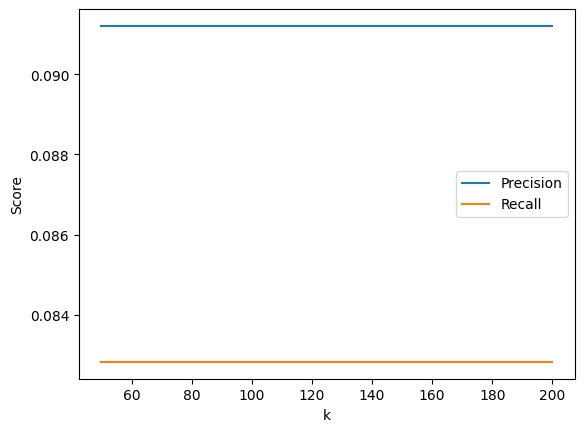

In [85]:
import matplotlib.pyplot as plt

# Define a list of possible values of k
k_values = [50, 100, 150, 200]

# Initialize empty lists to store the precision and recall scores for each value of k
precisions = []
recalls = []

# Evaluate the model for each value of k and append the scores to the lists
for k in k_values:
    precision, recall = evaluate_model(model, test_paper_ids[:100], embedding_map, reference_map, knn_k=k)
    precisions.append(precision)
    recalls.append(recall)

# Plot the precision and recall curves as a function of k
plt.plot(k_values, precisions, label="Precision")
plt.plot(k_values, recalls, label="Recall")
plt.xlabel("k")
plt.ylabel("Score")
plt.legend()
plt.show()
